## Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
from collections import OrderedDict
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


<hr>

## Parameters

In [38]:
parameters = {
    'batch_size': 64,
    'lr': 1e-4,
    'epochs': 100,
    'T': 30
}

<hr>

## Loading Files

In [3]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy')
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')

print(X.shape, y.shape)

(20000, 6, 28) (20000,)


In [4]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, X_val.shape)

(16000, 6, 28) (4000, 6, 28)


In [5]:
# Checking the label distribution of the train set
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
total = counts_train.sum()

print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels_train, counts_train):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

Label     Count     Percentage
------------------------------
0         7265      45.41%
1         2082      13.01%
2         6653      41.58%

Total samples: 16000


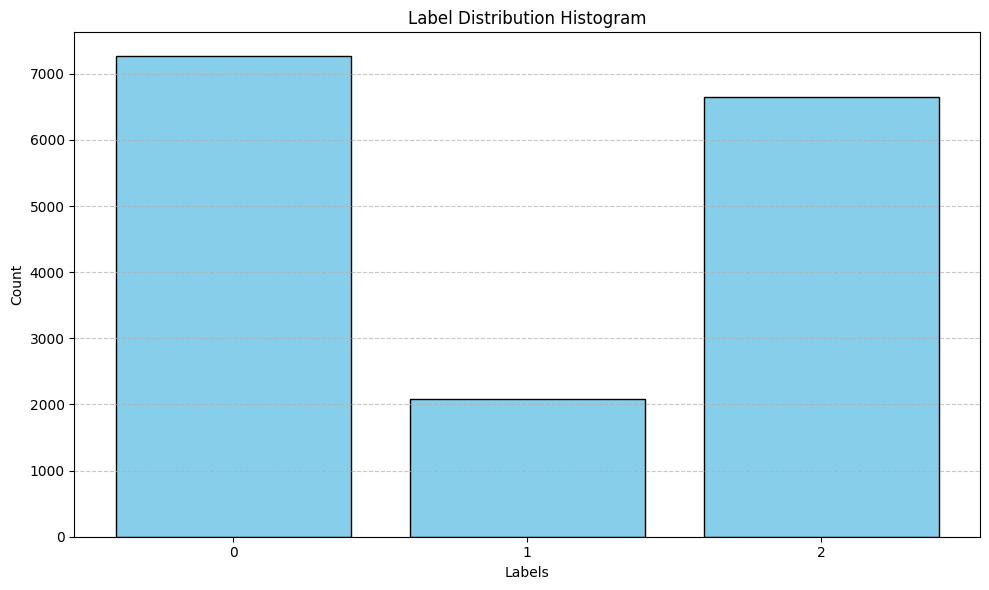

In [6]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(unique_labels_train.astype(str), counts_train, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution Histogram")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
# Checking the label distribution of the val set
unique_labels_val, counts_val = np.unique(y_val, return_counts=True)
total = counts_val.sum()

print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels_val, counts_val):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

Label     Count     Percentage
------------------------------
0         1816      45.40%
1         521       13.03%
2         1663      41.58%

Total samples: 4000


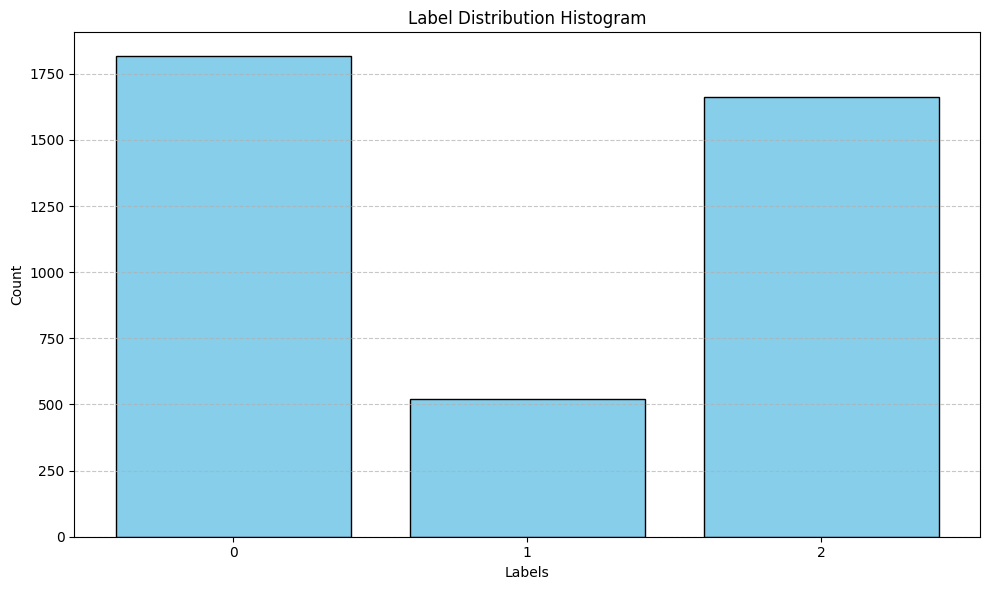

In [8]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(unique_labels_val.astype(str), counts_val, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution Histogram")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<hr>

## Dataset Class

In [9]:
class SimpleDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])  # shape: (6, 28)
        y = torch.tensor(self.labels[idx])
        return {"x": x, "y": y}

In [10]:
# For evaluation
val_dataset = SimpleDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=parameters['batch_size'], shuffle=False)

<hr>

## Model

In [20]:
################ CNN Backbone
def conv_block(in_channels: int, out_channels: int, dropout_p=0.5) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(p=dropout_p)
    )
 
 
class cnn_dropout(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.conv1 = conv_block(6, 64, dropout_p)
        self.conv2 = conv_block(64, 128, dropout_p)
        self.conv3 = conv_block(128, 256, dropout_p)
        self.conv4 = conv_block(256, 512, dropout_p)
        self.conv5 = conv_block(512, 1024, dropout_p)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        return x.view(x.size(0), -1)
 
 
################ Fully connected network
class FC_dropout(nn.Module):
    def __init__(self,input_dim, dropout_p=0.5):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        return self.fco(x)

In [39]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

# Initialize and load models
backbone = cnn_dropout()
backbone.to(device)

fc = FC_dropout(1024)
fc.to(device)

backbone.load_state_dict(backbone_state)
fc.load_state_dict(fc_state)

<All keys matched successfully>

In [22]:
# Enable dropout at inference/prediction (MC dropout)
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()  # Keep dropout in training mode

<hr>

## Evaluation Function

In [28]:
def mc_dropout_eval(backbone, fc, dataloader, T=20):
    backbone.eval()
    fc.eval()
    enable_dropout(backbone)
    enable_dropout(fc)

    all_preds = []
    all_labels = []
    all_uncertainties = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Validation"):
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            all_labels.append(y.cpu())

            mc_outputs = []
            for _ in range(T):
                feat = backbone(x)
                logits = fc(feat)
                probs = F.softmax(logits, dim=1)  # (B, num_classes)
                mc_outputs.append(probs.unsqueeze(0))  # (1, B, C)

            # Stack and average: (T, B, C) → (B, C)
            mc_outputs = torch.cat(mc_outputs, dim=0)  # (T, B, C)
            mc_mean = mc_outputs.mean(dim=0)  # (B, C)

            # Entropy: -sum(p * log(p))
            entropy = -(mc_mean * torch.log(mc_mean + 1e-10)).sum(dim=1)  # (B,)

            preds = torch.argmax(mc_mean, dim=1)
            all_preds.append(preds.cpu())
            all_uncertainties.append(entropy.cpu())

    # Concat all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_uncertainties = torch.cat(all_uncertainties).numpy()  # Shape: (N,)

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    avg_entropy = np.mean(all_uncertainties)

    return acc, f1_macro, f1_per_class, avg_entropy

<hr>

## Query Sampler (Aquisition Functions)

In [25]:
# # Initialize pools
# labeled_pool = set()
# unlabeled_pool = set(range(len(X)))  # {0, 1, ..., 19999}

# # ============= Predictive Entropy ============= 
# def predictive_entropy_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
#     model_backbone.eval()
#     model_fc.eval()
#     enable_dropout(model_backbone)
#     enable_dropout(model_fc)

#     indices = list(unlabeled_pool)
#     X_pool = X[indices]
#     mc_probs = []

#     with torch.no_grad():
#         for _ in range(sim):
#             logits = []
#             for i in range(0, len(X_pool), 32):
#                 x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
#                 feats = model_backbone(x_batch)
#                 out = model_fc(feats)
#                 logits.append(F.softmax(out, dim=1).cpu())
#             probs = torch.cat(logits, dim=0)
#             mc_probs.append(probs)

#     mc_probs = torch.stack(mc_probs)  # Shape: [T, N, C]
#     avg_probs = mc_probs.mean(dim=0)  # Shape: [N, C]
#     entropy = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)

#     topk = torch.topk(entropy, k=k).indices
#     return [indices[i.item()] for i in topk]

<hr>

## Training Loop

In [29]:
def train_model(backbone, fc, train_loader, val_loader, parameters, T=20):
    # Optimizer
    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(fc.parameters()), lr=parameters['lr'])

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(parameters['epochs']):
        backbone.train()
        fc.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{parameters['epochs']} [Training]"):
            x = batch['x'].to(device)
            y = batch['y'].to(device)

            optimizer.zero_grad()
            features = backbone(x)
            logits = fc(features)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        avg_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)

        # Validation with MC Dropout
        val_acc, val_avg_f1s, _, val_avg_entropy = mc_dropout_eval(backbone, fc, val_loader, T)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{parameters['epochs']} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    return train_losses, train_accuracies, val_accuracies, val_avg_f1s, val_avg_entropy

In [40]:
subset_sizes = list(range(2000, len(X_train) + 1, 2000))  # [2000, 4000, ..., 16000]

elbow_history = {
    "subset_size": [],
    "train_accuracy": [],
    "train_loss": [],
    "val_accuracy": [],
    "val_avg_f1": [],
    "val_uncertainty": []
}

for size in subset_sizes:
    print(f"\nTraining with {size} samples...")
    
    subset_indices = np.arange(size)
    X_subset = X_train[subset_indices]
    y_subset = y_train[subset_indices]

    # Create dataset & dataloader with WeightedRandomSampler
    dataset = SimpleDataset(X_subset, y_subset)

    class_counts = np.bincount(y_subset)
    weights = 1. / class_counts
    sample_weights = weights[y_subset]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    loader = DataLoader(dataset, batch_size=parameters['batch_size'], sampler=sampler, shuffle=False)

    # Fresh model for each subset
    backbone_model = cnn_dropout().to(device)
    fc_model = FC_dropout(1024).to(device)
    backbone_model.load_state_dict(backbone_state)
    fc_model.load_state_dict(fc_state)

    # Train
    train_losses, train_accs, val_accs, val_avg_f1s, val_entropy = train_model(backbone_model, fc_model, loader, val_dataloader, parameters, T=10)
    
    # Save final epoch stats
    elbow_history["subset_size"].append(size)
    elbow_history["train_loss"].append(train_losses[-1])
    elbow_history["train_accuracy"].append(train_accs[-1])
    elbow_history["val_accuracy"].append(val_accs[-1])
    elbow_history["val_avg_f1"].append(val_avg_f1s)
    elbow_history["val_uncertainty"].append(val_entropy)


Training with 2000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 1/100 | Train Loss: 2.6607 | Train Acc: 44.55% | Val Acc: 33.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 2/100 | Train Loss: 1.7902 | Train Acc: 54.35% | Val Acc: 60.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 3/100 | Train Loss: 1.4009 | Train Acc: 61.95% | Val Acc: 68.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch 4/100 | Train Loss: 1.1957 | Train Acc: 65.60% | Val Acc: 74.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 5/100 | Train Loss: 1.1233 | Train Acc: 66.25% | Val Acc: 76.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 6/100 | Train Loss: 1.0501 | Train Acc: 67.05% | Val Acc: 77.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 7/100 | Train Loss: 0.9646 | Train Acc: 69.90% | Val Acc: 75.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 8/100 | Train Loss: 0.9314 | Train Acc: 69.70% | Val Acc: 69.23%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 9/100 | Train Loss: 0.8550 | Train Acc: 72.20% | Val Acc: 78.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 10/100 | Train Loss: 0.8566 | Train Acc: 69.90% | Val Acc: 77.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 11/100 | Train Loss: 0.7421 | Train Acc: 73.20% | Val Acc: 78.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 12/100 | Train Loss: 0.7334 | Train Acc: 74.60% | Val Acc: 80.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 13/100 | Train Loss: 0.7604 | Train Acc: 73.05% | Val Acc: 79.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 14/100 | Train Loss: 0.7196 | Train Acc: 74.25% | Val Acc: 79.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 15/100 | Train Loss: 0.6953 | Train Acc: 74.15% | Val Acc: 78.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 16/100 | Train Loss: 0.6125 | Train Acc: 77.55% | Val Acc: 80.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch 17/100 | Train Loss: 0.6394 | Train Acc: 76.60% | Val Acc: 80.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 18/100 | Train Loss: 0.5958 | Train Acc: 77.35% | Val Acc: 77.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.96it/s]


Epoch 19/100 | Train Loss: 0.5994 | Train Acc: 77.15% | Val Acc: 81.23%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 20/100 | Train Loss: 0.5885 | Train Acc: 77.25% | Val Acc: 80.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 21/100 | Train Loss: 0.5928 | Train Acc: 77.35% | Val Acc: 82.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 22/100 | Train Loss: 0.5929 | Train Acc: 78.85% | Val Acc: 81.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 23/100 | Train Loss: 0.5664 | Train Acc: 78.20% | Val Acc: 81.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 24/100 | Train Loss: 0.6248 | Train Acc: 77.65% | Val Acc: 83.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 25/100 | Train Loss: 0.5594 | Train Acc: 78.30% | Val Acc: 81.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 26/100 | Train Loss: 0.5744 | Train Acc: 78.65% | Val Acc: 81.73%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 27/100 | Train Loss: 0.5503 | Train Acc: 79.45% | Val Acc: 83.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 28/100 | Train Loss: 0.5272 | Train Acc: 80.20% | Val Acc: 82.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 29/100 | Train Loss: 0.5126 | Train Acc: 79.85% | Val Acc: 82.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 30/100 | Train Loss: 0.5568 | Train Acc: 79.90% | Val Acc: 82.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 31/100 | Train Loss: 0.5473 | Train Acc: 78.80% | Val Acc: 84.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 32/100 | Train Loss: 0.4527 | Train Acc: 82.35% | Val Acc: 83.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.99it/s]


Epoch 33/100 | Train Loss: 0.4854 | Train Acc: 81.30% | Val Acc: 84.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 34/100 | Train Loss: 0.5300 | Train Acc: 79.65% | Val Acc: 85.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 35/100 | Train Loss: 0.4964 | Train Acc: 81.05% | Val Acc: 83.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 36/100 | Train Loss: 0.5433 | Train Acc: 79.65% | Val Acc: 85.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.97it/s]


Epoch 37/100 | Train Loss: 0.5048 | Train Acc: 82.00% | Val Acc: 83.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 38/100 | Train Loss: 0.5216 | Train Acc: 81.20% | Val Acc: 85.82%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 39/100 | Train Loss: 0.4386 | Train Acc: 83.90% | Val Acc: 84.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch 40/100 | Train Loss: 0.4716 | Train Acc: 82.45% | Val Acc: 84.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 41/100 | Train Loss: 0.4809 | Train Acc: 81.85% | Val Acc: 84.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 42/100 | Train Loss: 0.4752 | Train Acc: 81.80% | Val Acc: 84.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.94it/s]


Epoch 43/100 | Train Loss: 0.4562 | Train Acc: 82.15% | Val Acc: 84.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 44/100 | Train Loss: 0.5005 | Train Acc: 81.60% | Val Acc: 85.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 45/100 | Train Loss: 0.4295 | Train Acc: 83.35% | Val Acc: 85.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 46/100 | Train Loss: 0.4528 | Train Acc: 82.45% | Val Acc: 84.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.95it/s]


Epoch 47/100 | Train Loss: 0.4418 | Train Acc: 83.20% | Val Acc: 84.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.86it/s]


Epoch 48/100 | Train Loss: 0.4485 | Train Acc: 83.35% | Val Acc: 85.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 49/100 | Train Loss: 0.4289 | Train Acc: 83.05% | Val Acc: 85.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 50/100 | Train Loss: 0.4541 | Train Acc: 82.55% | Val Acc: 85.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.94it/s]


Epoch 51/100 | Train Loss: 0.4399 | Train Acc: 84.00% | Val Acc: 84.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch 52/100 | Train Loss: 0.4391 | Train Acc: 82.70% | Val Acc: 86.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.98it/s]


Epoch 53/100 | Train Loss: 0.4333 | Train Acc: 84.55% | Val Acc: 85.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 54/100 | Train Loss: 0.4070 | Train Acc: 84.55% | Val Acc: 85.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 55/100 | Train Loss: 0.4367 | Train Acc: 84.65% | Val Acc: 85.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 56/100 | Train Loss: 0.4187 | Train Acc: 84.15% | Val Acc: 85.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 57/100 | Train Loss: 0.4103 | Train Acc: 83.55% | Val Acc: 85.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 58/100 | Train Loss: 0.4218 | Train Acc: 85.50% | Val Acc: 86.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 59/100 | Train Loss: 0.4240 | Train Acc: 83.55% | Val Acc: 86.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 60/100 | Train Loss: 0.4665 | Train Acc: 83.00% | Val Acc: 85.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 61/100 | Train Loss: 0.4327 | Train Acc: 83.75% | Val Acc: 86.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 62/100 | Train Loss: 0.4179 | Train Acc: 84.00% | Val Acc: 85.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 63/100 | Train Loss: 0.4009 | Train Acc: 84.75% | Val Acc: 86.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 64/100 | Train Loss: 0.3866 | Train Acc: 86.15% | Val Acc: 86.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 65/100 | Train Loss: 0.3956 | Train Acc: 85.85% | Val Acc: 85.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 66/100 | Train Loss: 0.4210 | Train Acc: 84.10% | Val Acc: 86.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 67/100 | Train Loss: 0.4162 | Train Acc: 84.75% | Val Acc: 86.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 68/100 | Train Loss: 0.4151 | Train Acc: 84.35% | Val Acc: 86.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 69/100 | Train Loss: 0.3893 | Train Acc: 85.65% | Val Acc: 86.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 70/100 | Train Loss: 0.3785 | Train Acc: 86.15% | Val Acc: 86.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 71/100 | Train Loss: 0.4230 | Train Acc: 82.45% | Val Acc: 85.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 72/100 | Train Loss: 0.4126 | Train Acc: 84.65% | Val Acc: 86.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 73/100 | Train Loss: 0.3827 | Train Acc: 86.00% | Val Acc: 86.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 74/100 | Train Loss: 0.3687 | Train Acc: 85.65% | Val Acc: 86.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 75/100 | Train Loss: 0.3664 | Train Acc: 86.20% | Val Acc: 86.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 76/100 | Train Loss: 0.4003 | Train Acc: 85.15% | Val Acc: 85.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 77/100 | Train Loss: 0.4183 | Train Acc: 84.25% | Val Acc: 86.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 78/100 | Train Loss: 0.3544 | Train Acc: 86.10% | Val Acc: 86.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 79/100 | Train Loss: 0.3514 | Train Acc: 86.75% | Val Acc: 86.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 80/100 | Train Loss: 0.3797 | Train Acc: 84.95% | Val Acc: 86.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 81/100 | Train Loss: 0.3544 | Train Acc: 85.45% | Val Acc: 87.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 82/100 | Train Loss: 0.3562 | Train Acc: 86.90% | Val Acc: 86.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 83/100 | Train Loss: 0.3586 | Train Acc: 85.75% | Val Acc: 86.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 84/100 | Train Loss: 0.3477 | Train Acc: 86.60% | Val Acc: 86.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.78it/s]


Epoch 85/100 | Train Loss: 0.3292 | Train Acc: 87.25% | Val Acc: 87.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.78it/s]


Epoch 86/100 | Train Loss: 0.3684 | Train Acc: 86.70% | Val Acc: 86.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.85it/s]


Epoch 87/100 | Train Loss: 0.3497 | Train Acc: 86.95% | Val Acc: 86.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.90it/s]


Epoch 88/100 | Train Loss: 0.3247 | Train Acc: 87.35% | Val Acc: 87.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 89/100 | Train Loss: 0.3697 | Train Acc: 85.90% | Val Acc: 86.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 90/100 | Train Loss: 0.3612 | Train Acc: 85.85% | Val Acc: 86.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.92it/s]


Epoch 91/100 | Train Loss: 0.3493 | Train Acc: 86.50% | Val Acc: 85.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 92/100 | Train Loss: 0.3379 | Train Acc: 87.25% | Val Acc: 86.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.97it/s]


Epoch 93/100 | Train Loss: 0.3666 | Train Acc: 87.45% | Val Acc: 86.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 94/100 | Train Loss: 0.3286 | Train Acc: 88.05% | Val Acc: 87.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 95/100 | Train Loss: 0.3161 | Train Acc: 88.40% | Val Acc: 86.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 96/100 | Train Loss: 0.3142 | Train Acc: 88.35% | Val Acc: 87.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 97/100 | Train Loss: 0.3586 | Train Acc: 86.95% | Val Acc: 87.02%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 98/100 | Train Loss: 0.3640 | Train Acc: 87.75% | Val Acc: 85.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 99/100 | Train Loss: 0.3609 | Train Acc: 86.30% | Val Acc: 86.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 100/100 | Train Loss: 0.3515 | Train Acc: 87.50% | Val Acc: 86.22%

Training with 4000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 1/100 | Train Loss: 2.1834 | Train Acc: 50.40% | Val Acc: 62.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 2/100 | Train Loss: 1.2661 | Train Acc: 63.73% | Val Acc: 75.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 3/100 | Train Loss: 1.0434 | Train Acc: 67.53% | Val Acc: 73.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 4/100 | Train Loss: 0.8870 | Train Acc: 70.08% | Val Acc: 79.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 5/100 | Train Loss: 0.8274 | Train Acc: 72.38% | Val Acc: 79.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 6/100 | Train Loss: 0.7495 | Train Acc: 72.88% | Val Acc: 77.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 7/100 | Train Loss: 0.7054 | Train Acc: 75.33% | Val Acc: 80.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 8/100 | Train Loss: 0.6793 | Train Acc: 74.67% | Val Acc: 81.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 9/100 | Train Loss: 0.6136 | Train Acc: 77.38% | Val Acc: 82.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 10/100 | Train Loss: 0.5838 | Train Acc: 78.62% | Val Acc: 81.73%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 11/100 | Train Loss: 0.5774 | Train Acc: 78.57% | Val Acc: 81.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 12/100 | Train Loss: 0.5873 | Train Acc: 78.50% | Val Acc: 82.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 13/100 | Train Loss: 0.5240 | Train Acc: 79.88% | Val Acc: 84.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.24it/s]


Epoch 14/100 | Train Loss: 0.5497 | Train Acc: 78.90% | Val Acc: 83.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 15/100 | Train Loss: 0.5417 | Train Acc: 80.38% | Val Acc: 84.82%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 16/100 | Train Loss: 0.5129 | Train Acc: 80.88% | Val Acc: 84.82%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 17/100 | Train Loss: 0.5099 | Train Acc: 81.15% | Val Acc: 83.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 18/100 | Train Loss: 0.4838 | Train Acc: 82.17% | Val Acc: 84.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 19/100 | Train Loss: 0.4822 | Train Acc: 82.50% | Val Acc: 84.82%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 20/100 | Train Loss: 0.5098 | Train Acc: 81.70% | Val Acc: 84.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 21/100 | Train Loss: 0.4874 | Train Acc: 81.70% | Val Acc: 85.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 22/100 | Train Loss: 0.4680 | Train Acc: 82.45% | Val Acc: 84.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 23/100 | Train Loss: 0.4557 | Train Acc: 83.30% | Val Acc: 84.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 24/100 | Train Loss: 0.4583 | Train Acc: 83.95% | Val Acc: 84.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 25/100 | Train Loss: 0.4573 | Train Acc: 82.60% | Val Acc: 85.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 26/100 | Train Loss: 0.4376 | Train Acc: 83.75% | Val Acc: 85.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 27/100 | Train Loss: 0.4403 | Train Acc: 84.12% | Val Acc: 85.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 28/100 | Train Loss: 0.4246 | Train Acc: 84.72% | Val Acc: 86.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 29/100 | Train Loss: 0.4193 | Train Acc: 84.17% | Val Acc: 86.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 30/100 | Train Loss: 0.4224 | Train Acc: 83.83% | Val Acc: 86.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 31/100 | Train Loss: 0.4002 | Train Acc: 85.25% | Val Acc: 86.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch 32/100 | Train Loss: 0.4093 | Train Acc: 84.62% | Val Acc: 86.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 33/100 | Train Loss: 0.4038 | Train Acc: 84.70% | Val Acc: 87.02%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 34/100 | Train Loss: 0.3887 | Train Acc: 85.10% | Val Acc: 86.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 35/100 | Train Loss: 0.4219 | Train Acc: 84.15% | Val Acc: 86.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch 36/100 | Train Loss: 0.3918 | Train Acc: 84.97% | Val Acc: 86.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 37/100 | Train Loss: 0.3836 | Train Acc: 85.78% | Val Acc: 87.02%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 38/100 | Train Loss: 0.3888 | Train Acc: 85.55% | Val Acc: 87.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 39/100 | Train Loss: 0.3982 | Train Acc: 84.95% | Val Acc: 87.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.98it/s]


Epoch 40/100 | Train Loss: 0.3640 | Train Acc: 86.00% | Val Acc: 87.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 41/100 | Train Loss: 0.3873 | Train Acc: 85.65% | Val Acc: 87.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 42/100 | Train Loss: 0.3611 | Train Acc: 86.58% | Val Acc: 87.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 43/100 | Train Loss: 0.4079 | Train Acc: 84.78% | Val Acc: 86.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 44/100 | Train Loss: 0.3852 | Train Acc: 85.60% | Val Acc: 86.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 45/100 | Train Loss: 0.3908 | Train Acc: 85.75% | Val Acc: 86.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 46/100 | Train Loss: 0.3783 | Train Acc: 86.33% | Val Acc: 87.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 47/100 | Train Loss: 0.3430 | Train Acc: 87.28% | Val Acc: 87.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 48/100 | Train Loss: 0.3548 | Train Acc: 86.78% | Val Acc: 87.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 49/100 | Train Loss: 0.3551 | Train Acc: 86.70% | Val Acc: 87.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 50/100 | Train Loss: 0.3794 | Train Acc: 86.28% | Val Acc: 87.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 51/100 | Train Loss: 0.3541 | Train Acc: 85.95% | Val Acc: 87.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 52/100 | Train Loss: 0.3600 | Train Acc: 86.08% | Val Acc: 87.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 53/100 | Train Loss: 0.3259 | Train Acc: 87.45% | Val Acc: 87.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 54/100 | Train Loss: 0.3340 | Train Acc: 87.58% | Val Acc: 87.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 55/100 | Train Loss: 0.3367 | Train Acc: 87.05% | Val Acc: 87.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 56/100 | Train Loss: 0.3258 | Train Acc: 87.52% | Val Acc: 87.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.19it/s]


Epoch 57/100 | Train Loss: 0.3441 | Train Acc: 86.98% | Val Acc: 87.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 58/100 | Train Loss: 0.3850 | Train Acc: 86.02% | Val Acc: 87.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.19it/s]


Epoch 59/100 | Train Loss: 0.3432 | Train Acc: 86.90% | Val Acc: 87.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 60/100 | Train Loss: 0.3373 | Train Acc: 87.08% | Val Acc: 87.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 61/100 | Train Loss: 0.3199 | Train Acc: 87.60% | Val Acc: 87.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.19it/s]


Epoch 62/100 | Train Loss: 0.3361 | Train Acc: 86.88% | Val Acc: 87.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 63/100 | Train Loss: 0.3274 | Train Acc: 88.02% | Val Acc: 88.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 64/100 | Train Loss: 0.3439 | Train Acc: 87.35% | Val Acc: 87.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 65/100 | Train Loss: 0.3294 | Train Acc: 87.62% | Val Acc: 87.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 66/100 | Train Loss: 0.3173 | Train Acc: 87.98% | Val Acc: 87.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 67/100 | Train Loss: 0.3267 | Train Acc: 87.70% | Val Acc: 87.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 68/100 | Train Loss: 0.3206 | Train Acc: 87.88% | Val Acc: 87.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 69/100 | Train Loss: 0.3288 | Train Acc: 87.30% | Val Acc: 87.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 70/100 | Train Loss: 0.3040 | Train Acc: 88.50% | Val Acc: 87.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 71/100 | Train Loss: 0.3285 | Train Acc: 88.10% | Val Acc: 87.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 72/100 | Train Loss: 0.3104 | Train Acc: 87.88% | Val Acc: 87.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 73/100 | Train Loss: 0.3214 | Train Acc: 87.70% | Val Acc: 87.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.19it/s]


Epoch 74/100 | Train Loss: 0.3031 | Train Acc: 88.38% | Val Acc: 87.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 75/100 | Train Loss: 0.3139 | Train Acc: 87.75% | Val Acc: 87.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 76/100 | Train Loss: 0.2839 | Train Acc: 89.22% | Val Acc: 87.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 77/100 | Train Loss: 0.3058 | Train Acc: 88.00% | Val Acc: 87.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 78/100 | Train Loss: 0.3123 | Train Acc: 88.10% | Val Acc: 87.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 79/100 | Train Loss: 0.3108 | Train Acc: 88.38% | Val Acc: 88.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 80/100 | Train Loss: 0.3007 | Train Acc: 88.33% | Val Acc: 87.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 81/100 | Train Loss: 0.3074 | Train Acc: 87.98% | Val Acc: 87.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 82/100 | Train Loss: 0.3047 | Train Acc: 88.33% | Val Acc: 88.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 83/100 | Train Loss: 0.3183 | Train Acc: 87.65% | Val Acc: 87.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 84/100 | Train Loss: 0.3044 | Train Acc: 88.10% | Val Acc: 87.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 85/100 | Train Loss: 0.2994 | Train Acc: 88.72% | Val Acc: 87.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 86/100 | Train Loss: 0.2958 | Train Acc: 88.20% | Val Acc: 87.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 87/100 | Train Loss: 0.3056 | Train Acc: 88.33% | Val Acc: 87.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 88/100 | Train Loss: 0.2922 | Train Acc: 88.88% | Val Acc: 88.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 89/100 | Train Loss: 0.2924 | Train Acc: 88.70% | Val Acc: 87.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 90/100 | Train Loss: 0.2739 | Train Acc: 89.42% | Val Acc: 87.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 91/100 | Train Loss: 0.3110 | Train Acc: 87.60% | Val Acc: 88.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 92/100 | Train Loss: 0.3061 | Train Acc: 87.95% | Val Acc: 87.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 93/100 | Train Loss: 0.2978 | Train Acc: 88.12% | Val Acc: 87.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 94/100 | Train Loss: 0.2823 | Train Acc: 89.28% | Val Acc: 88.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 95/100 | Train Loss: 0.2988 | Train Acc: 88.80% | Val Acc: 87.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 96/100 | Train Loss: 0.2887 | Train Acc: 88.88% | Val Acc: 87.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 97/100 | Train Loss: 0.2860 | Train Acc: 89.08% | Val Acc: 88.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 98/100 | Train Loss: 0.2831 | Train Acc: 89.00% | Val Acc: 88.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 99/100 | Train Loss: 0.2830 | Train Acc: 89.33% | Val Acc: 87.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 100/100 | Train Loss: 0.2566 | Train Acc: 89.53% | Val Acc: 87.80%

Training with 6000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 1/100 | Train Loss: 1.8600 | Train Acc: 55.33% | Val Acc: 70.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 2/100 | Train Loss: 1.0889 | Train Acc: 67.15% | Val Acc: 78.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 3/100 | Train Loss: 0.8736 | Train Acc: 70.47% | Val Acc: 77.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 4/100 | Train Loss: 0.7813 | Train Acc: 73.32% | Val Acc: 80.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 5/100 | Train Loss: 0.6801 | Train Acc: 75.05% | Val Acc: 81.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 6/100 | Train Loss: 0.6369 | Train Acc: 77.28% | Val Acc: 82.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 7/100 | Train Loss: 0.5889 | Train Acc: 77.97% | Val Acc: 83.53%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 8/100 | Train Loss: 0.5664 | Train Acc: 79.28% | Val Acc: 83.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.95it/s]


Epoch 9/100 | Train Loss: 0.5393 | Train Acc: 80.20% | Val Acc: 84.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 10/100 | Train Loss: 0.5358 | Train Acc: 80.45% | Val Acc: 83.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.23it/s]


Epoch 11/100 | Train Loss: 0.4998 | Train Acc: 81.80% | Val Acc: 84.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.23it/s]


Epoch 12/100 | Train Loss: 0.5087 | Train Acc: 80.72% | Val Acc: 85.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 13/100 | Train Loss: 0.4815 | Train Acc: 81.85% | Val Acc: 85.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 14/100 | Train Loss: 0.4617 | Train Acc: 82.60% | Val Acc: 84.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 15/100 | Train Loss: 0.4599 | Train Acc: 83.07% | Val Acc: 86.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.96it/s]


Epoch 16/100 | Train Loss: 0.4625 | Train Acc: 83.17% | Val Acc: 85.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.98it/s]


Epoch 17/100 | Train Loss: 0.4619 | Train Acc: 83.58% | Val Acc: 86.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 18/100 | Train Loss: 0.4489 | Train Acc: 83.33% | Val Acc: 85.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 19/100 | Train Loss: 0.4277 | Train Acc: 84.63% | Val Acc: 86.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 20/100 | Train Loss: 0.4060 | Train Acc: 85.28% | Val Acc: 86.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 21/100 | Train Loss: 0.4066 | Train Acc: 85.28% | Val Acc: 86.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 22/100 | Train Loss: 0.4137 | Train Acc: 85.03% | Val Acc: 86.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 23/100 | Train Loss: 0.4233 | Train Acc: 85.13% | Val Acc: 86.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 24/100 | Train Loss: 0.4045 | Train Acc: 85.40% | Val Acc: 87.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 25/100 | Train Loss: 0.3834 | Train Acc: 85.70% | Val Acc: 87.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 26/100 | Train Loss: 0.4098 | Train Acc: 84.90% | Val Acc: 87.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 27/100 | Train Loss: 0.3778 | Train Acc: 86.30% | Val Acc: 87.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 28/100 | Train Loss: 0.3820 | Train Acc: 85.65% | Val Acc: 87.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 29/100 | Train Loss: 0.3725 | Train Acc: 86.18% | Val Acc: 87.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 30/100 | Train Loss: 0.3810 | Train Acc: 85.62% | Val Acc: 87.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.93it/s]


Epoch 31/100 | Train Loss: 0.3633 | Train Acc: 86.48% | Val Acc: 87.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 32/100 | Train Loss: 0.3558 | Train Acc: 86.57% | Val Acc: 86.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 33/100 | Train Loss: 0.3570 | Train Acc: 86.75% | Val Acc: 87.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 34/100 | Train Loss: 0.3508 | Train Acc: 86.80% | Val Acc: 87.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 35/100 | Train Loss: 0.3496 | Train Acc: 87.47% | Val Acc: 87.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.95it/s]


Epoch 36/100 | Train Loss: 0.3590 | Train Acc: 86.63% | Val Acc: 87.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 37/100 | Train Loss: 0.3478 | Train Acc: 86.60% | Val Acc: 87.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 38/100 | Train Loss: 0.3471 | Train Acc: 86.98% | Val Acc: 88.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 39/100 | Train Loss: 0.3486 | Train Acc: 87.17% | Val Acc: 87.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 40/100 | Train Loss: 0.3420 | Train Acc: 87.28% | Val Acc: 87.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 41/100 | Train Loss: 0.3360 | Train Acc: 87.25% | Val Acc: 87.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 42/100 | Train Loss: 0.3572 | Train Acc: 87.00% | Val Acc: 87.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 43/100 | Train Loss: 0.3328 | Train Acc: 87.77% | Val Acc: 88.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 44/100 | Train Loss: 0.3221 | Train Acc: 88.10% | Val Acc: 87.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 45/100 | Train Loss: 0.3254 | Train Acc: 88.18% | Val Acc: 87.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.96it/s]


Epoch 46/100 | Train Loss: 0.3192 | Train Acc: 88.47% | Val Acc: 87.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 47/100 | Train Loss: 0.3082 | Train Acc: 88.77% | Val Acc: 87.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 48/100 | Train Loss: 0.3303 | Train Acc: 88.12% | Val Acc: 87.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 49/100 | Train Loss: 0.3236 | Train Acc: 88.23% | Val Acc: 88.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 50/100 | Train Loss: 0.3190 | Train Acc: 88.02% | Val Acc: 87.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 51/100 | Train Loss: 0.3393 | Train Acc: 87.23% | Val Acc: 87.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 52/100 | Train Loss: 0.3231 | Train Acc: 88.08% | Val Acc: 88.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 53/100 | Train Loss: 0.3092 | Train Acc: 89.03% | Val Acc: 88.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 54/100 | Train Loss: 0.3124 | Train Acc: 88.17% | Val Acc: 87.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 55/100 | Train Loss: 0.2960 | Train Acc: 88.47% | Val Acc: 88.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.98it/s]


Epoch 56/100 | Train Loss: 0.3051 | Train Acc: 88.70% | Val Acc: 88.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch 57/100 | Train Loss: 0.2951 | Train Acc: 88.87% | Val Acc: 87.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 58/100 | Train Loss: 0.3125 | Train Acc: 88.48% | Val Acc: 88.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 59/100 | Train Loss: 0.2956 | Train Acc: 88.92% | Val Acc: 88.02%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 60/100 | Train Loss: 0.2986 | Train Acc: 88.82% | Val Acc: 88.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 61/100 | Train Loss: 0.3127 | Train Acc: 88.28% | Val Acc: 88.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 62/100 | Train Loss: 0.2887 | Train Acc: 89.47% | Val Acc: 88.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.99it/s]


Epoch 63/100 | Train Loss: 0.3020 | Train Acc: 88.60% | Val Acc: 88.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.99it/s]


Epoch 64/100 | Train Loss: 0.2951 | Train Acc: 88.82% | Val Acc: 87.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 65/100 | Train Loss: 0.2816 | Train Acc: 89.28% | Val Acc: 88.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.99it/s]


Epoch 66/100 | Train Loss: 0.3061 | Train Acc: 88.35% | Val Acc: 87.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 67/100 | Train Loss: 0.2822 | Train Acc: 89.15% | Val Acc: 88.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 68/100 | Train Loss: 0.2881 | Train Acc: 89.05% | Val Acc: 88.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 69/100 | Train Loss: 0.2911 | Train Acc: 88.75% | Val Acc: 88.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 70/100 | Train Loss: 0.2661 | Train Acc: 90.12% | Val Acc: 88.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 71/100 | Train Loss: 0.2971 | Train Acc: 88.92% | Val Acc: 88.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.23it/s]


Epoch 72/100 | Train Loss: 0.2882 | Train Acc: 89.27% | Val Acc: 88.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 73/100 | Train Loss: 0.2961 | Train Acc: 89.23% | Val Acc: 87.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 74/100 | Train Loss: 0.2839 | Train Acc: 89.10% | Val Acc: 88.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 75/100 | Train Loss: 0.2921 | Train Acc: 88.87% | Val Acc: 87.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 76/100 | Train Loss: 0.2695 | Train Acc: 89.75% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 77/100 | Train Loss: 0.2733 | Train Acc: 89.60% | Val Acc: 88.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 78/100 | Train Loss: 0.2807 | Train Acc: 89.35% | Val Acc: 88.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 79/100 | Train Loss: 0.2801 | Train Acc: 89.32% | Val Acc: 88.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 80/100 | Train Loss: 0.2723 | Train Acc: 89.42% | Val Acc: 88.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 81/100 | Train Loss: 0.2728 | Train Acc: 89.47% | Val Acc: 88.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 82/100 | Train Loss: 0.2845 | Train Acc: 89.23% | Val Acc: 88.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 83/100 | Train Loss: 0.2822 | Train Acc: 89.80% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 84/100 | Train Loss: 0.2493 | Train Acc: 90.37% | Val Acc: 88.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 85/100 | Train Loss: 0.2625 | Train Acc: 89.77% | Val Acc: 88.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 86/100 | Train Loss: 0.2670 | Train Acc: 89.57% | Val Acc: 88.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 87/100 | Train Loss: 0.2596 | Train Acc: 90.18% | Val Acc: 88.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 88/100 | Train Loss: 0.2621 | Train Acc: 89.92% | Val Acc: 88.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 89/100 | Train Loss: 0.2576 | Train Acc: 89.95% | Val Acc: 88.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 90/100 | Train Loss: 0.2634 | Train Acc: 89.52% | Val Acc: 89.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 91/100 | Train Loss: 0.2708 | Train Acc: 89.28% | Val Acc: 88.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 92/100 | Train Loss: 0.2503 | Train Acc: 90.40% | Val Acc: 88.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 93/100 | Train Loss: 0.2565 | Train Acc: 90.12% | Val Acc: 88.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 94/100 | Train Loss: 0.2637 | Train Acc: 89.67% | Val Acc: 88.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 95/100 | Train Loss: 0.2612 | Train Acc: 90.03% | Val Acc: 89.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 96/100 | Train Loss: 0.2464 | Train Acc: 90.65% | Val Acc: 88.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 97/100 | Train Loss: 0.2398 | Train Acc: 90.35% | Val Acc: 88.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.95it/s]


Epoch 98/100 | Train Loss: 0.2635 | Train Acc: 89.95% | Val Acc: 88.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch 99/100 | Train Loss: 0.2399 | Train Acc: 90.98% | Val Acc: 88.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 100/100 | Train Loss: 0.2609 | Train Acc: 89.77% | Val Acc: 88.78%

Training with 8000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 1/100 | Train Loss: 1.6681 | Train Acc: 58.33% | Val Acc: 75.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 2/100 | Train Loss: 0.9371 | Train Acc: 70.47% | Val Acc: 79.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 3/100 | Train Loss: 0.7894 | Train Acc: 72.67% | Val Acc: 79.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 4/100 | Train Loss: 0.6589 | Train Acc: 76.41% | Val Acc: 80.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 5/100 | Train Loss: 0.5862 | Train Acc: 78.41% | Val Acc: 82.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 6/100 | Train Loss: 0.5955 | Train Acc: 78.84% | Val Acc: 83.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 7/100 | Train Loss: 0.5323 | Train Acc: 80.76% | Val Acc: 83.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 8/100 | Train Loss: 0.5254 | Train Acc: 80.86% | Val Acc: 84.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 9/100 | Train Loss: 0.4988 | Train Acc: 81.73% | Val Acc: 85.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 10/100 | Train Loss: 0.5081 | Train Acc: 81.36% | Val Acc: 82.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 11/100 | Train Loss: 0.4384 | Train Acc: 83.71% | Val Acc: 85.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 12/100 | Train Loss: 0.4535 | Train Acc: 83.40% | Val Acc: 86.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 13/100 | Train Loss: 0.4508 | Train Acc: 83.75% | Val Acc: 86.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.99it/s]


Epoch 14/100 | Train Loss: 0.4256 | Train Acc: 84.49% | Val Acc: 84.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 15/100 | Train Loss: 0.4077 | Train Acc: 85.32% | Val Acc: 86.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 16/100 | Train Loss: 0.4120 | Train Acc: 85.10% | Val Acc: 87.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 17/100 | Train Loss: 0.4221 | Train Acc: 84.71% | Val Acc: 86.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 18/100 | Train Loss: 0.4009 | Train Acc: 85.44% | Val Acc: 86.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 19/100 | Train Loss: 0.3879 | Train Acc: 86.48% | Val Acc: 87.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 20/100 | Train Loss: 0.3822 | Train Acc: 86.11% | Val Acc: 86.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 21/100 | Train Loss: 0.4012 | Train Acc: 85.41% | Val Acc: 87.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 22/100 | Train Loss: 0.3607 | Train Acc: 86.79% | Val Acc: 86.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 23/100 | Train Loss: 0.3767 | Train Acc: 86.09% | Val Acc: 87.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 24/100 | Train Loss: 0.3755 | Train Acc: 86.42% | Val Acc: 87.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 25/100 | Train Loss: 0.3455 | Train Acc: 87.09% | Val Acc: 87.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 26/100 | Train Loss: 0.3469 | Train Acc: 87.35% | Val Acc: 86.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 27/100 | Train Loss: 0.3590 | Train Acc: 86.74% | Val Acc: 87.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 28/100 | Train Loss: 0.3449 | Train Acc: 87.46% | Val Acc: 87.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 29/100 | Train Loss: 0.3512 | Train Acc: 87.12% | Val Acc: 87.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 30/100 | Train Loss: 0.3263 | Train Acc: 88.40% | Val Acc: 86.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 31/100 | Train Loss: 0.3400 | Train Acc: 87.71% | Val Acc: 87.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 32/100 | Train Loss: 0.3500 | Train Acc: 86.95% | Val Acc: 87.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 33/100 | Train Loss: 0.3329 | Train Acc: 87.58% | Val Acc: 87.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 34/100 | Train Loss: 0.3464 | Train Acc: 87.33% | Val Acc: 87.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 35/100 | Train Loss: 0.3146 | Train Acc: 88.11% | Val Acc: 87.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 36/100 | Train Loss: 0.3293 | Train Acc: 88.04% | Val Acc: 87.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 37/100 | Train Loss: 0.3238 | Train Acc: 88.09% | Val Acc: 87.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 38/100 | Train Loss: 0.3265 | Train Acc: 88.04% | Val Acc: 87.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 39/100 | Train Loss: 0.3249 | Train Acc: 87.98% | Val Acc: 87.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 40/100 | Train Loss: 0.3240 | Train Acc: 88.40% | Val Acc: 87.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 41/100 | Train Loss: 0.3076 | Train Acc: 88.66% | Val Acc: 87.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 42/100 | Train Loss: 0.3259 | Train Acc: 88.04% | Val Acc: 87.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.98it/s]


Epoch 43/100 | Train Loss: 0.3008 | Train Acc: 88.72% | Val Acc: 87.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch 44/100 | Train Loss: 0.3193 | Train Acc: 88.01% | Val Acc: 88.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 45/100 | Train Loss: 0.2916 | Train Acc: 89.30% | Val Acc: 88.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.95it/s]


Epoch 46/100 | Train Loss: 0.3136 | Train Acc: 87.98% | Val Acc: 87.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 47/100 | Train Loss: 0.3018 | Train Acc: 89.03% | Val Acc: 87.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 48/100 | Train Loss: 0.2976 | Train Acc: 89.08% | Val Acc: 88.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 49/100 | Train Loss: 0.2994 | Train Acc: 89.03% | Val Acc: 88.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 50/100 | Train Loss: 0.3161 | Train Acc: 88.22% | Val Acc: 88.02%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 51/100 | Train Loss: 0.3096 | Train Acc: 88.34% | Val Acc: 88.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.98it/s]


Epoch 52/100 | Train Loss: 0.3007 | Train Acc: 88.62% | Val Acc: 88.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 53/100 | Train Loss: 0.2917 | Train Acc: 88.88% | Val Acc: 88.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 54/100 | Train Loss: 0.2937 | Train Acc: 88.80% | Val Acc: 87.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 55/100 | Train Loss: 0.2916 | Train Acc: 88.51% | Val Acc: 88.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 56/100 | Train Loss: 0.2908 | Train Acc: 88.75% | Val Acc: 88.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 57/100 | Train Loss: 0.2829 | Train Acc: 89.05% | Val Acc: 88.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 58/100 | Train Loss: 0.2832 | Train Acc: 89.05% | Val Acc: 88.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 59/100 | Train Loss: 0.2748 | Train Acc: 89.60% | Val Acc: 88.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 60/100 | Train Loss: 0.2740 | Train Acc: 89.68% | Val Acc: 88.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 61/100 | Train Loss: 0.2825 | Train Acc: 89.33% | Val Acc: 88.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 62/100 | Train Loss: 0.2770 | Train Acc: 89.46% | Val Acc: 88.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 63/100 | Train Loss: 0.2744 | Train Acc: 89.36% | Val Acc: 89.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 64/100 | Train Loss: 0.2857 | Train Acc: 89.15% | Val Acc: 88.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 65/100 | Train Loss: 0.2769 | Train Acc: 89.65% | Val Acc: 88.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.99it/s]


Epoch 66/100 | Train Loss: 0.2679 | Train Acc: 90.16% | Val Acc: 88.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 67/100 | Train Loss: 0.2730 | Train Acc: 89.68% | Val Acc: 88.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 68/100 | Train Loss: 0.2620 | Train Acc: 90.24% | Val Acc: 88.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 69/100 | Train Loss: 0.2620 | Train Acc: 89.90% | Val Acc: 88.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 70/100 | Train Loss: 0.2682 | Train Acc: 89.91% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 71/100 | Train Loss: 0.2701 | Train Acc: 89.45% | Val Acc: 88.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.89it/s]


Epoch 72/100 | Train Loss: 0.2707 | Train Acc: 89.36% | Val Acc: 88.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 73/100 | Train Loss: 0.2652 | Train Acc: 89.61% | Val Acc: 88.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 74/100 | Train Loss: 0.2664 | Train Acc: 89.79% | Val Acc: 88.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 75/100 | Train Loss: 0.2497 | Train Acc: 90.49% | Val Acc: 88.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 76/100 | Train Loss: 0.2559 | Train Acc: 90.31% | Val Acc: 88.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 77/100 | Train Loss: 0.2676 | Train Acc: 89.56% | Val Acc: 88.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.97it/s]


Epoch 78/100 | Train Loss: 0.2501 | Train Acc: 90.85% | Val Acc: 88.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 79/100 | Train Loss: 0.2659 | Train Acc: 90.09% | Val Acc: 88.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 80/100 | Train Loss: 0.2570 | Train Acc: 89.76% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.99it/s]


Epoch 81/100 | Train Loss: 0.2634 | Train Acc: 90.06% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 82/100 | Train Loss: 0.2580 | Train Acc: 90.31% | Val Acc: 88.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 83/100 | Train Loss: 0.2539 | Train Acc: 90.49% | Val Acc: 89.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.98it/s]


Epoch 84/100 | Train Loss: 0.2441 | Train Acc: 90.88% | Val Acc: 88.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 85/100 | Train Loss: 0.2665 | Train Acc: 90.11% | Val Acc: 88.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 86/100 | Train Loss: 0.2425 | Train Acc: 90.58% | Val Acc: 88.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 87/100 | Train Loss: 0.2552 | Train Acc: 90.06% | Val Acc: 89.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 88/100 | Train Loss: 0.2450 | Train Acc: 90.49% | Val Acc: 88.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 89/100 | Train Loss: 0.2410 | Train Acc: 90.74% | Val Acc: 88.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 90/100 | Train Loss: 0.2380 | Train Acc: 90.94% | Val Acc: 89.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 91/100 | Train Loss: 0.2490 | Train Acc: 90.55% | Val Acc: 88.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 92/100 | Train Loss: 0.2413 | Train Acc: 90.79% | Val Acc: 89.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 93/100 | Train Loss: 0.2447 | Train Acc: 90.70% | Val Acc: 88.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 94/100 | Train Loss: 0.2515 | Train Acc: 90.24% | Val Acc: 88.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 95/100 | Train Loss: 0.2515 | Train Acc: 90.62% | Val Acc: 88.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 96/100 | Train Loss: 0.2424 | Train Acc: 90.79% | Val Acc: 88.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 97/100 | Train Loss: 0.2403 | Train Acc: 90.69% | Val Acc: 88.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 98/100 | Train Loss: 0.2536 | Train Acc: 90.51% | Val Acc: 89.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 99/100 | Train Loss: 0.2454 | Train Acc: 90.77% | Val Acc: 89.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 100/100 | Train Loss: 0.2443 | Train Acc: 90.79% | Val Acc: 89.28%

Training with 10000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 1/100 | Train Loss: 1.5465 | Train Acc: 60.78% | Val Acc: 75.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 2/100 | Train Loss: 0.8595 | Train Acc: 71.72% | Val Acc: 72.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 3/100 | Train Loss: 0.6917 | Train Acc: 74.74% | Val Acc: 81.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 4/100 | Train Loss: 0.6268 | Train Acc: 76.58% | Val Acc: 82.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 5/100 | Train Loss: 0.5677 | Train Acc: 79.72% | Val Acc: 83.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 6/100 | Train Loss: 0.5296 | Train Acc: 79.94% | Val Acc: 84.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 7/100 | Train Loss: 0.4929 | Train Acc: 82.16% | Val Acc: 83.93%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 8/100 | Train Loss: 0.4870 | Train Acc: 82.55% | Val Acc: 85.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.92it/s]


Epoch 9/100 | Train Loss: 0.4813 | Train Acc: 82.67% | Val Acc: 84.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 10/100 | Train Loss: 0.4436 | Train Acc: 83.98% | Val Acc: 86.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.99it/s]


Epoch 11/100 | Train Loss: 0.4064 | Train Acc: 84.98% | Val Acc: 86.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 12/100 | Train Loss: 0.4248 | Train Acc: 84.56% | Val Acc: 86.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 13/100 | Train Loss: 0.4219 | Train Acc: 84.83% | Val Acc: 86.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.89it/s]


Epoch 14/100 | Train Loss: 0.3920 | Train Acc: 85.48% | Val Acc: 86.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 15/100 | Train Loss: 0.4151 | Train Acc: 84.71% | Val Acc: 86.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 16/100 | Train Loss: 0.3891 | Train Acc: 85.94% | Val Acc: 87.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 17/100 | Train Loss: 0.3899 | Train Acc: 86.56% | Val Acc: 87.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 18/100 | Train Loss: 0.3700 | Train Acc: 86.83% | Val Acc: 86.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 19/100 | Train Loss: 0.3689 | Train Acc: 86.37% | Val Acc: 86.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 20/100 | Train Loss: 0.3779 | Train Acc: 86.17% | Val Acc: 87.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 21/100 | Train Loss: 0.3622 | Train Acc: 86.74% | Val Acc: 86.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 22/100 | Train Loss: 0.3503 | Train Acc: 87.12% | Val Acc: 87.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 23/100 | Train Loss: 0.3535 | Train Acc: 86.84% | Val Acc: 87.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.97it/s]


Epoch 24/100 | Train Loss: 0.3419 | Train Acc: 87.82% | Val Acc: 87.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 25/100 | Train Loss: 0.3297 | Train Acc: 87.87% | Val Acc: 87.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 26/100 | Train Loss: 0.3594 | Train Acc: 86.70% | Val Acc: 87.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 27/100 | Train Loss: 0.3311 | Train Acc: 87.73% | Val Acc: 87.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 28/100 | Train Loss: 0.3314 | Train Acc: 87.58% | Val Acc: 87.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 29/100 | Train Loss: 0.3191 | Train Acc: 88.20% | Val Acc: 88.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 30/100 | Train Loss: 0.3352 | Train Acc: 87.54% | Val Acc: 87.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 31/100 | Train Loss: 0.3285 | Train Acc: 88.03% | Val Acc: 88.02%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 32/100 | Train Loss: 0.3179 | Train Acc: 87.85% | Val Acc: 88.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 33/100 | Train Loss: 0.3013 | Train Acc: 89.27% | Val Acc: 87.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 34/100 | Train Loss: 0.3127 | Train Acc: 88.25% | Val Acc: 88.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 35/100 | Train Loss: 0.3052 | Train Acc: 88.39% | Val Acc: 88.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 36/100 | Train Loss: 0.3229 | Train Acc: 88.32% | Val Acc: 87.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 37/100 | Train Loss: 0.3015 | Train Acc: 89.02% | Val Acc: 88.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 38/100 | Train Loss: 0.2987 | Train Acc: 88.61% | Val Acc: 87.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 39/100 | Train Loss: 0.3086 | Train Acc: 88.63% | Val Acc: 88.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 40/100 | Train Loss: 0.3026 | Train Acc: 88.61% | Val Acc: 88.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 41/100 | Train Loss: 0.3122 | Train Acc: 88.49% | Val Acc: 88.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 42/100 | Train Loss: 0.2931 | Train Acc: 89.13% | Val Acc: 87.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 43/100 | Train Loss: 0.3006 | Train Acc: 88.94% | Val Acc: 88.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 44/100 | Train Loss: 0.2880 | Train Acc: 89.27% | Val Acc: 88.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 45/100 | Train Loss: 0.2772 | Train Acc: 89.83% | Val Acc: 88.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.19it/s]


Epoch 46/100 | Train Loss: 0.2925 | Train Acc: 89.42% | Val Acc: 88.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 47/100 | Train Loss: 0.2864 | Train Acc: 89.32% | Val Acc: 88.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 48/100 | Train Loss: 0.2802 | Train Acc: 89.23% | Val Acc: 88.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 49/100 | Train Loss: 0.2925 | Train Acc: 88.77% | Val Acc: 88.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 50/100 | Train Loss: 0.2851 | Train Acc: 89.70% | Val Acc: 88.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 51/100 | Train Loss: 0.2891 | Train Acc: 89.43% | Val Acc: 88.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 52/100 | Train Loss: 0.2756 | Train Acc: 89.61% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 53/100 | Train Loss: 0.2737 | Train Acc: 89.65% | Val Acc: 88.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 54/100 | Train Loss: 0.2735 | Train Acc: 89.28% | Val Acc: 88.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 55/100 | Train Loss: 0.2894 | Train Acc: 89.19% | Val Acc: 88.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 56/100 | Train Loss: 0.2713 | Train Acc: 89.60% | Val Acc: 88.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 57/100 | Train Loss: 0.2677 | Train Acc: 90.11% | Val Acc: 88.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.05it/s]


Epoch 58/100 | Train Loss: 0.2697 | Train Acc: 89.77% | Val Acc: 88.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 59/100 | Train Loss: 0.2660 | Train Acc: 89.96% | Val Acc: 88.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 60/100 | Train Loss: 0.2750 | Train Acc: 89.95% | Val Acc: 88.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 61/100 | Train Loss: 0.2731 | Train Acc: 89.77% | Val Acc: 88.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 62/100 | Train Loss: 0.2711 | Train Acc: 89.79% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 63/100 | Train Loss: 0.2609 | Train Acc: 90.16% | Val Acc: 89.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 64/100 | Train Loss: 0.2710 | Train Acc: 89.79% | Val Acc: 89.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.98it/s]


Epoch 65/100 | Train Loss: 0.2647 | Train Acc: 90.01% | Val Acc: 88.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 66/100 | Train Loss: 0.2617 | Train Acc: 90.00% | Val Acc: 88.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 67/100 | Train Loss: 0.2607 | Train Acc: 90.20% | Val Acc: 88.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 68/100 | Train Loss: 0.2545 | Train Acc: 90.57% | Val Acc: 89.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 69/100 | Train Loss: 0.2668 | Train Acc: 89.77% | Val Acc: 89.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 70/100 | Train Loss: 0.2631 | Train Acc: 89.92% | Val Acc: 89.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 71/100 | Train Loss: 0.2555 | Train Acc: 90.45% | Val Acc: 88.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 72/100 | Train Loss: 0.2569 | Train Acc: 90.26% | Val Acc: 89.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.25it/s]


Epoch 73/100 | Train Loss: 0.2631 | Train Acc: 90.04% | Val Acc: 88.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 74/100 | Train Loss: 0.2490 | Train Acc: 90.37% | Val Acc: 88.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 75/100 | Train Loss: 0.2615 | Train Acc: 90.00% | Val Acc: 89.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 76/100 | Train Loss: 0.2503 | Train Acc: 90.53% | Val Acc: 88.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 77/100 | Train Loss: 0.2575 | Train Acc: 89.84% | Val Acc: 89.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.99it/s]


Epoch 78/100 | Train Loss: 0.2442 | Train Acc: 90.79% | Val Acc: 89.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 79/100 | Train Loss: 0.2499 | Train Acc: 90.49% | Val Acc: 88.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 80/100 | Train Loss: 0.2522 | Train Acc: 90.39% | Val Acc: 89.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 81/100 | Train Loss: 0.2520 | Train Acc: 90.67% | Val Acc: 89.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 82/100 | Train Loss: 0.2526 | Train Acc: 90.22% | Val Acc: 88.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 83/100 | Train Loss: 0.2468 | Train Acc: 90.41% | Val Acc: 88.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 84/100 | Train Loss: 0.2438 | Train Acc: 90.77% | Val Acc: 89.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 85/100 | Train Loss: 0.2393 | Train Acc: 90.72% | Val Acc: 88.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 86/100 | Train Loss: 0.2573 | Train Acc: 90.34% | Val Acc: 89.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 87/100 | Train Loss: 0.2431 | Train Acc: 90.74% | Val Acc: 89.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 88/100 | Train Loss: 0.2409 | Train Acc: 90.88% | Val Acc: 89.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 89/100 | Train Loss: 0.2345 | Train Acc: 90.94% | Val Acc: 89.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 90/100 | Train Loss: 0.2439 | Train Acc: 90.46% | Val Acc: 89.53%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 91/100 | Train Loss: 0.2304 | Train Acc: 91.07% | Val Acc: 88.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 92/100 | Train Loss: 0.2413 | Train Acc: 90.68% | Val Acc: 89.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 93/100 | Train Loss: 0.2469 | Train Acc: 90.60% | Val Acc: 89.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 94/100 | Train Loss: 0.2417 | Train Acc: 90.47% | Val Acc: 89.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 95/100 | Train Loss: 0.2391 | Train Acc: 90.89% | Val Acc: 89.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch 96/100 | Train Loss: 0.2414 | Train Acc: 90.83% | Val Acc: 89.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.97it/s]


Epoch 97/100 | Train Loss: 0.2381 | Train Acc: 90.79% | Val Acc: 89.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 98/100 | Train Loss: 0.2366 | Train Acc: 90.88% | Val Acc: 89.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.12it/s]


Epoch 99/100 | Train Loss: 0.2411 | Train Acc: 90.72% | Val Acc: 89.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 100/100 | Train Loss: 0.2391 | Train Acc: 91.10% | Val Acc: 89.12%

Training with 12000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 1/100 | Train Loss: 1.4729 | Train Acc: 61.50% | Val Acc: 77.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 2/100 | Train Loss: 0.8136 | Train Acc: 72.38% | Val Acc: 81.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.04it/s]


Epoch 3/100 | Train Loss: 0.6698 | Train Acc: 76.43% | Val Acc: 83.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 4/100 | Train Loss: 0.5636 | Train Acc: 79.58% | Val Acc: 82.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.98it/s]


Epoch 5/100 | Train Loss: 0.5228 | Train Acc: 81.09% | Val Acc: 84.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 6/100 | Train Loss: 0.5102 | Train Acc: 81.26% | Val Acc: 85.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 7/100 | Train Loss: 0.4725 | Train Acc: 82.96% | Val Acc: 85.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 38.98it/s]


Epoch 8/100 | Train Loss: 0.4536 | Train Acc: 83.31% | Val Acc: 85.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 9/100 | Train Loss: 0.4513 | Train Acc: 83.43% | Val Acc: 86.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 10/100 | Train Loss: 0.4247 | Train Acc: 84.50% | Val Acc: 86.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 11/100 | Train Loss: 0.4200 | Train Acc: 84.65% | Val Acc: 86.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 12/100 | Train Loss: 0.4002 | Train Acc: 85.07% | Val Acc: 86.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 13/100 | Train Loss: 0.4013 | Train Acc: 85.25% | Val Acc: 87.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch 14/100 | Train Loss: 0.3838 | Train Acc: 85.46% | Val Acc: 87.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 15/100 | Train Loss: 0.3797 | Train Acc: 86.22% | Val Acc: 87.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 16/100 | Train Loss: 0.3656 | Train Acc: 85.97% | Val Acc: 87.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.10it/s]


Epoch 17/100 | Train Loss: 0.3702 | Train Acc: 86.51% | Val Acc: 87.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 18/100 | Train Loss: 0.3476 | Train Acc: 87.23% | Val Acc: 87.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.23it/s]


Epoch 19/100 | Train Loss: 0.3567 | Train Acc: 87.12% | Val Acc: 87.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 20/100 | Train Loss: 0.3601 | Train Acc: 86.88% | Val Acc: 87.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 21/100 | Train Loss: 0.3461 | Train Acc: 87.02% | Val Acc: 87.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 22/100 | Train Loss: 0.3453 | Train Acc: 87.17% | Val Acc: 87.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 23/100 | Train Loss: 0.3299 | Train Acc: 87.60% | Val Acc: 87.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 24/100 | Train Loss: 0.3283 | Train Acc: 87.76% | Val Acc: 87.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 25/100 | Train Loss: 0.3283 | Train Acc: 87.72% | Val Acc: 87.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 26/100 | Train Loss: 0.3343 | Train Acc: 87.35% | Val Acc: 88.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 27/100 | Train Loss: 0.3350 | Train Acc: 87.55% | Val Acc: 87.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 28/100 | Train Loss: 0.3151 | Train Acc: 88.17% | Val Acc: 87.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 29/100 | Train Loss: 0.3165 | Train Acc: 87.80% | Val Acc: 87.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 30/100 | Train Loss: 0.3213 | Train Acc: 87.90% | Val Acc: 88.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.03it/s]


Epoch 31/100 | Train Loss: 0.3103 | Train Acc: 88.35% | Val Acc: 88.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 32/100 | Train Loss: 0.3062 | Train Acc: 88.38% | Val Acc: 87.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 33/100 | Train Loss: 0.3034 | Train Acc: 88.62% | Val Acc: 88.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 34/100 | Train Loss: 0.3022 | Train Acc: 88.58% | Val Acc: 87.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 35/100 | Train Loss: 0.2888 | Train Acc: 88.79% | Val Acc: 88.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 36/100 | Train Loss: 0.3129 | Train Acc: 88.12% | Val Acc: 88.02%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 37/100 | Train Loss: 0.2917 | Train Acc: 89.03% | Val Acc: 88.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 38/100 | Train Loss: 0.2940 | Train Acc: 88.87% | Val Acc: 88.02%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 39/100 | Train Loss: 0.2877 | Train Acc: 89.34% | Val Acc: 88.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 40/100 | Train Loss: 0.2941 | Train Acc: 88.92% | Val Acc: 88.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 41/100 | Train Loss: 0.2912 | Train Acc: 88.72% | Val Acc: 88.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 42/100 | Train Loss: 0.2939 | Train Acc: 88.88% | Val Acc: 88.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 43/100 | Train Loss: 0.2927 | Train Acc: 88.67% | Val Acc: 88.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 44/100 | Train Loss: 0.2883 | Train Acc: 89.21% | Val Acc: 88.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 45/100 | Train Loss: 0.2787 | Train Acc: 89.42% | Val Acc: 87.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.51it/s]


Epoch 46/100 | Train Loss: 0.3028 | Train Acc: 88.43% | Val Acc: 88.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 47/100 | Train Loss: 0.2782 | Train Acc: 89.22% | Val Acc: 88.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 48/100 | Train Loss: 0.2763 | Train Acc: 89.17% | Val Acc: 88.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 49/100 | Train Loss: 0.2742 | Train Acc: 89.00% | Val Acc: 88.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 50/100 | Train Loss: 0.2814 | Train Acc: 89.02% | Val Acc: 88.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 51/100 | Train Loss: 0.2809 | Train Acc: 89.58% | Val Acc: 88.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 52/100 | Train Loss: 0.2749 | Train Acc: 89.28% | Val Acc: 88.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 53/100 | Train Loss: 0.2625 | Train Acc: 90.02% | Val Acc: 88.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 54/100 | Train Loss: 0.2866 | Train Acc: 89.36% | Val Acc: 88.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 55/100 | Train Loss: 0.2705 | Train Acc: 89.87% | Val Acc: 89.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 56/100 | Train Loss: 0.2735 | Train Acc: 89.50% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 57/100 | Train Loss: 0.2730 | Train Acc: 89.83% | Val Acc: 88.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 58/100 | Train Loss: 0.2633 | Train Acc: 89.91% | Val Acc: 88.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 59/100 | Train Loss: 0.2627 | Train Acc: 89.91% | Val Acc: 88.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 60/100 | Train Loss: 0.2543 | Train Acc: 90.05% | Val Acc: 88.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 61/100 | Train Loss: 0.2687 | Train Acc: 89.88% | Val Acc: 88.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 62/100 | Train Loss: 0.2681 | Train Acc: 89.57% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 63/100 | Train Loss: 0.2583 | Train Acc: 90.18% | Val Acc: 89.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 64/100 | Train Loss: 0.2608 | Train Acc: 89.98% | Val Acc: 89.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.23it/s]


Epoch 65/100 | Train Loss: 0.2595 | Train Acc: 90.24% | Val Acc: 89.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 66/100 | Train Loss: 0.2741 | Train Acc: 89.28% | Val Acc: 89.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 67/100 | Train Loss: 0.2606 | Train Acc: 89.96% | Val Acc: 89.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 68/100 | Train Loss: 0.2648 | Train Acc: 89.78% | Val Acc: 89.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 69/100 | Train Loss: 0.2668 | Train Acc: 89.73% | Val Acc: 89.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch 70/100 | Train Loss: 0.2511 | Train Acc: 90.34% | Val Acc: 89.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.02it/s]


Epoch 71/100 | Train Loss: 0.2612 | Train Acc: 90.06% | Val Acc: 89.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 72/100 | Train Loss: 0.2452 | Train Acc: 90.29% | Val Acc: 89.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 73/100 | Train Loss: 0.2466 | Train Acc: 90.51% | Val Acc: 88.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.13it/s]


Epoch 74/100 | Train Loss: 0.2495 | Train Acc: 90.38% | Val Acc: 88.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 75/100 | Train Loss: 0.2627 | Train Acc: 90.08% | Val Acc: 89.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.09it/s]


Epoch 76/100 | Train Loss: 0.2482 | Train Acc: 90.41% | Val Acc: 89.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 77/100 | Train Loss: 0.2545 | Train Acc: 90.14% | Val Acc: 89.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 78/100 | Train Loss: 0.2444 | Train Acc: 90.58% | Val Acc: 88.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 79/100 | Train Loss: 0.2490 | Train Acc: 90.53% | Val Acc: 88.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.50it/s]


Epoch 80/100 | Train Loss: 0.2457 | Train Acc: 90.72% | Val Acc: 88.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 81/100 | Train Loss: 0.2528 | Train Acc: 90.38% | Val Acc: 89.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 82/100 | Train Loss: 0.2442 | Train Acc: 90.37% | Val Acc: 89.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 83/100 | Train Loss: 0.2454 | Train Acc: 90.88% | Val Acc: 89.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 84/100 | Train Loss: 0.2375 | Train Acc: 91.05% | Val Acc: 89.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 85/100 | Train Loss: 0.2594 | Train Acc: 89.96% | Val Acc: 89.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 86/100 | Train Loss: 0.2467 | Train Acc: 90.28% | Val Acc: 89.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 87/100 | Train Loss: 0.2441 | Train Acc: 90.75% | Val Acc: 89.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 88/100 | Train Loss: 0.2429 | Train Acc: 90.80% | Val Acc: 88.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 89/100 | Train Loss: 0.2470 | Train Acc: 90.62% | Val Acc: 89.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 90/100 | Train Loss: 0.2416 | Train Acc: 90.81% | Val Acc: 89.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 91/100 | Train Loss: 0.2316 | Train Acc: 91.10% | Val Acc: 89.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 92/100 | Train Loss: 0.2446 | Train Acc: 90.45% | Val Acc: 89.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 93/100 | Train Loss: 0.2357 | Train Acc: 90.88% | Val Acc: 89.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 94/100 | Train Loss: 0.2387 | Train Acc: 90.78% | Val Acc: 89.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 95/100 | Train Loss: 0.2279 | Train Acc: 91.03% | Val Acc: 89.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 96/100 | Train Loss: 0.2302 | Train Acc: 91.17% | Val Acc: 89.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 97/100 | Train Loss: 0.2390 | Train Acc: 91.00% | Val Acc: 89.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.23it/s]


Epoch 98/100 | Train Loss: 0.2269 | Train Acc: 91.27% | Val Acc: 89.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 99/100 | Train Loss: 0.2416 | Train Acc: 90.71% | Val Acc: 89.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 100/100 | Train Loss: 0.2266 | Train Acc: 91.04% | Val Acc: 89.00%

Training with 14000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 1/100 | Train Loss: 1.4131 | Train Acc: 62.80% | Val Acc: 78.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 2/100 | Train Loss: 0.7771 | Train Acc: 72.76% | Val Acc: 79.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 3/100 | Train Loss: 0.6420 | Train Acc: 76.95% | Val Acc: 83.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 4/100 | Train Loss: 0.5580 | Train Acc: 79.54% | Val Acc: 84.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 5/100 | Train Loss: 0.5104 | Train Acc: 81.70% | Val Acc: 85.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 6/100 | Train Loss: 0.4895 | Train Acc: 82.00% | Val Acc: 85.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 7/100 | Train Loss: 0.4642 | Train Acc: 82.99% | Val Acc: 85.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 8/100 | Train Loss: 0.4425 | Train Acc: 83.48% | Val Acc: 86.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 9/100 | Train Loss: 0.4216 | Train Acc: 84.66% | Val Acc: 86.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 10/100 | Train Loss: 0.4223 | Train Acc: 84.51% | Val Acc: 86.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 11/100 | Train Loss: 0.3839 | Train Acc: 85.59% | Val Acc: 86.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 12/100 | Train Loss: 0.3948 | Train Acc: 85.54% | Val Acc: 87.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 13/100 | Train Loss: 0.3816 | Train Acc: 85.84% | Val Acc: 87.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 14/100 | Train Loss: 0.3689 | Train Acc: 86.41% | Val Acc: 87.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 15/100 | Train Loss: 0.3618 | Train Acc: 86.66% | Val Acc: 88.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 16/100 | Train Loss: 0.3664 | Train Acc: 86.41% | Val Acc: 87.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 17/100 | Train Loss: 0.3532 | Train Acc: 87.14% | Val Acc: 88.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 18/100 | Train Loss: 0.3492 | Train Acc: 86.96% | Val Acc: 87.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 19/100 | Train Loss: 0.3287 | Train Acc: 87.55% | Val Acc: 87.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 20/100 | Train Loss: 0.3494 | Train Acc: 86.94% | Val Acc: 87.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 21/100 | Train Loss: 0.3371 | Train Acc: 87.42% | Val Acc: 87.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 22/100 | Train Loss: 0.3325 | Train Acc: 87.53% | Val Acc: 87.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 23/100 | Train Loss: 0.3147 | Train Acc: 88.33% | Val Acc: 87.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 24/100 | Train Loss: 0.3387 | Train Acc: 87.28% | Val Acc: 87.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 25/100 | Train Loss: 0.3125 | Train Acc: 88.41% | Val Acc: 87.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 26/100 | Train Loss: 0.3017 | Train Acc: 88.64% | Val Acc: 87.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 27/100 | Train Loss: 0.3145 | Train Acc: 88.21% | Val Acc: 87.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 28/100 | Train Loss: 0.3130 | Train Acc: 88.36% | Val Acc: 88.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 29/100 | Train Loss: 0.3097 | Train Acc: 88.35% | Val Acc: 88.02%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 30/100 | Train Loss: 0.3117 | Train Acc: 87.86% | Val Acc: 88.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 31/100 | Train Loss: 0.3153 | Train Acc: 88.09% | Val Acc: 88.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 32/100 | Train Loss: 0.3060 | Train Acc: 88.45% | Val Acc: 88.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 33/100 | Train Loss: 0.2946 | Train Acc: 88.80% | Val Acc: 88.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 34/100 | Train Loss: 0.2905 | Train Acc: 88.85% | Val Acc: 88.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 35/100 | Train Loss: 0.3032 | Train Acc: 88.37% | Val Acc: 88.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 36/100 | Train Loss: 0.2970 | Train Acc: 88.81% | Val Acc: 88.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 37/100 | Train Loss: 0.2882 | Train Acc: 89.05% | Val Acc: 88.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 38/100 | Train Loss: 0.2991 | Train Acc: 88.75% | Val Acc: 88.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 39/100 | Train Loss: 0.2859 | Train Acc: 88.97% | Val Acc: 88.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 40/100 | Train Loss: 0.2890 | Train Acc: 89.01% | Val Acc: 88.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 41/100 | Train Loss: 0.2932 | Train Acc: 88.86% | Val Acc: 88.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 42/100 | Train Loss: 0.2828 | Train Acc: 89.19% | Val Acc: 88.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.50it/s]


Epoch 43/100 | Train Loss: 0.2902 | Train Acc: 88.91% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 44/100 | Train Loss: 0.2870 | Train Acc: 89.06% | Val Acc: 88.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 45/100 | Train Loss: 0.2881 | Train Acc: 89.01% | Val Acc: 88.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 46/100 | Train Loss: 0.2767 | Train Acc: 89.55% | Val Acc: 88.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 47/100 | Train Loss: 0.2780 | Train Acc: 89.29% | Val Acc: 88.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 48/100 | Train Loss: 0.2812 | Train Acc: 89.04% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 49/100 | Train Loss: 0.2735 | Train Acc: 90.01% | Val Acc: 88.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 50/100 | Train Loss: 0.2841 | Train Acc: 88.89% | Val Acc: 88.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 51/100 | Train Loss: 0.2723 | Train Acc: 89.57% | Val Acc: 88.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 52/100 | Train Loss: 0.2682 | Train Acc: 89.56% | Val Acc: 88.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 53/100 | Train Loss: 0.2696 | Train Acc: 89.61% | Val Acc: 88.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 54/100 | Train Loss: 0.2636 | Train Acc: 90.07% | Val Acc: 88.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 55/100 | Train Loss: 0.2751 | Train Acc: 89.54% | Val Acc: 89.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 56/100 | Train Loss: 0.2690 | Train Acc: 89.46% | Val Acc: 88.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 57/100 | Train Loss: 0.2558 | Train Acc: 90.11% | Val Acc: 88.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 58/100 | Train Loss: 0.2710 | Train Acc: 89.68% | Val Acc: 88.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 59/100 | Train Loss: 0.2644 | Train Acc: 90.04% | Val Acc: 88.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 60/100 | Train Loss: 0.2583 | Train Acc: 89.96% | Val Acc: 88.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 61/100 | Train Loss: 0.2533 | Train Acc: 90.38% | Val Acc: 89.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 62/100 | Train Loss: 0.2499 | Train Acc: 90.34% | Val Acc: 89.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 63/100 | Train Loss: 0.2512 | Train Acc: 90.37% | Val Acc: 89.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 64/100 | Train Loss: 0.2649 | Train Acc: 89.67% | Val Acc: 89.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 65/100 | Train Loss: 0.2625 | Train Acc: 89.99% | Val Acc: 88.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 66/100 | Train Loss: 0.2500 | Train Acc: 90.47% | Val Acc: 89.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 67/100 | Train Loss: 0.2635 | Train Acc: 89.83% | Val Acc: 88.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 68/100 | Train Loss: 0.2570 | Train Acc: 90.04% | Val Acc: 88.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 69/100 | Train Loss: 0.2527 | Train Acc: 90.28% | Val Acc: 89.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 70/100 | Train Loss: 0.2509 | Train Acc: 90.41% | Val Acc: 89.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 71/100 | Train Loss: 0.2587 | Train Acc: 90.09% | Val Acc: 89.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 72/100 | Train Loss: 0.2421 | Train Acc: 90.53% | Val Acc: 89.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 73/100 | Train Loss: 0.2533 | Train Acc: 90.11% | Val Acc: 88.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 74/100 | Train Loss: 0.2479 | Train Acc: 90.63% | Val Acc: 88.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 75/100 | Train Loss: 0.2565 | Train Acc: 90.14% | Val Acc: 89.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 76/100 | Train Loss: 0.2535 | Train Acc: 90.19% | Val Acc: 89.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 77/100 | Train Loss: 0.2389 | Train Acc: 90.60% | Val Acc: 89.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 78/100 | Train Loss: 0.2481 | Train Acc: 90.61% | Val Acc: 88.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 79/100 | Train Loss: 0.2398 | Train Acc: 90.89% | Val Acc: 89.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.19it/s]


Epoch 80/100 | Train Loss: 0.2476 | Train Acc: 90.13% | Val Acc: 89.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 81/100 | Train Loss: 0.2357 | Train Acc: 90.84% | Val Acc: 89.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 82/100 | Train Loss: 0.2507 | Train Acc: 90.27% | Val Acc: 89.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 83/100 | Train Loss: 0.2304 | Train Acc: 91.23% | Val Acc: 89.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 84/100 | Train Loss: 0.2439 | Train Acc: 90.54% | Val Acc: 89.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 85/100 | Train Loss: 0.2458 | Train Acc: 90.71% | Val Acc: 88.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.52it/s]


Epoch 86/100 | Train Loss: 0.2377 | Train Acc: 90.81% | Val Acc: 89.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 87/100 | Train Loss: 0.2505 | Train Acc: 90.16% | Val Acc: 89.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 88/100 | Train Loss: 0.2297 | Train Acc: 90.99% | Val Acc: 89.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 89/100 | Train Loss: 0.2326 | Train Acc: 90.89% | Val Acc: 88.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.50it/s]


Epoch 90/100 | Train Loss: 0.2480 | Train Acc: 90.74% | Val Acc: 89.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 91/100 | Train Loss: 0.2436 | Train Acc: 90.71% | Val Acc: 89.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 92/100 | Train Loss: 0.2354 | Train Acc: 90.96% | Val Acc: 88.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 93/100 | Train Loss: 0.2293 | Train Acc: 91.09% | Val Acc: 89.68%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.50it/s]


Epoch 94/100 | Train Loss: 0.2363 | Train Acc: 90.84% | Val Acc: 89.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 95/100 | Train Loss: 0.2305 | Train Acc: 91.16% | Val Acc: 89.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 96/100 | Train Loss: 0.2402 | Train Acc: 90.87% | Val Acc: 89.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 97/100 | Train Loss: 0.2318 | Train Acc: 91.19% | Val Acc: 89.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 98/100 | Train Loss: 0.2409 | Train Acc: 90.66% | Val Acc: 89.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 99/100 | Train Loss: 0.2355 | Train Acc: 91.01% | Val Acc: 89.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 100/100 | Train Loss: 0.2321 | Train Acc: 90.86% | Val Acc: 89.42%

Training with 16000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 1/100 | Train Loss: 1.3167 | Train Acc: 63.99% | Val Acc: 77.68%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 2/100 | Train Loss: 0.7407 | Train Acc: 73.47% | Val Acc: 81.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 3/100 | Train Loss: 0.6043 | Train Acc: 77.64% | Val Acc: 82.93%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 4/100 | Train Loss: 0.5318 | Train Acc: 80.32% | Val Acc: 84.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 5/100 | Train Loss: 0.4931 | Train Acc: 81.71% | Val Acc: 84.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 6/100 | Train Loss: 0.4756 | Train Acc: 82.26% | Val Acc: 85.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 7/100 | Train Loss: 0.4554 | Train Acc: 83.03% | Val Acc: 85.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 8/100 | Train Loss: 0.4214 | Train Acc: 84.74% | Val Acc: 86.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 9/100 | Train Loss: 0.4083 | Train Acc: 85.12% | Val Acc: 85.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 10/100 | Train Loss: 0.4052 | Train Acc: 84.98% | Val Acc: 86.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 11/100 | Train Loss: 0.3789 | Train Acc: 86.04% | Val Acc: 86.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 12/100 | Train Loss: 0.3882 | Train Acc: 85.41% | Val Acc: 87.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 13/100 | Train Loss: 0.3717 | Train Acc: 85.99% | Val Acc: 87.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 14/100 | Train Loss: 0.3567 | Train Acc: 86.86% | Val Acc: 87.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.53it/s]


Epoch 15/100 | Train Loss: 0.3627 | Train Acc: 86.49% | Val Acc: 87.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 16/100 | Train Loss: 0.3460 | Train Acc: 86.89% | Val Acc: 87.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 17/100 | Train Loss: 0.3364 | Train Acc: 87.29% | Val Acc: 87.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 18/100 | Train Loss: 0.3439 | Train Acc: 87.21% | Val Acc: 87.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 19/100 | Train Loss: 0.3369 | Train Acc: 87.28% | Val Acc: 87.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.51it/s]


Epoch 20/100 | Train Loss: 0.3338 | Train Acc: 87.44% | Val Acc: 87.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 21/100 | Train Loss: 0.3365 | Train Acc: 86.97% | Val Acc: 87.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.52it/s]


Epoch 22/100 | Train Loss: 0.3236 | Train Acc: 87.56% | Val Acc: 88.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 23/100 | Train Loss: 0.3248 | Train Acc: 87.84% | Val Acc: 87.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 24/100 | Train Loss: 0.3136 | Train Acc: 88.10% | Val Acc: 87.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 25/100 | Train Loss: 0.3121 | Train Acc: 87.98% | Val Acc: 88.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 26/100 | Train Loss: 0.3101 | Train Acc: 88.37% | Val Acc: 88.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 27/100 | Train Loss: 0.3072 | Train Acc: 88.22% | Val Acc: 88.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 28/100 | Train Loss: 0.3039 | Train Acc: 88.76% | Val Acc: 88.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 29/100 | Train Loss: 0.3110 | Train Acc: 88.25% | Val Acc: 88.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 30/100 | Train Loss: 0.3026 | Train Acc: 88.66% | Val Acc: 88.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 31/100 | Train Loss: 0.3037 | Train Acc: 88.13% | Val Acc: 88.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.51it/s]


Epoch 32/100 | Train Loss: 0.2967 | Train Acc: 88.67% | Val Acc: 88.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 33/100 | Train Loss: 0.2905 | Train Acc: 88.83% | Val Acc: 87.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 34/100 | Train Loss: 0.2971 | Train Acc: 88.84% | Val Acc: 88.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 35/100 | Train Loss: 0.2869 | Train Acc: 89.09% | Val Acc: 88.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 36/100 | Train Loss: 0.2955 | Train Acc: 88.66% | Val Acc: 88.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 37/100 | Train Loss: 0.2927 | Train Acc: 88.58% | Val Acc: 89.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 38/100 | Train Loss: 0.2864 | Train Acc: 89.04% | Val Acc: 88.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 39/100 | Train Loss: 0.2915 | Train Acc: 88.91% | Val Acc: 88.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 40/100 | Train Loss: 0.2775 | Train Acc: 89.28% | Val Acc: 88.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 41/100 | Train Loss: 0.2799 | Train Acc: 89.26% | Val Acc: 88.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 42/100 | Train Loss: 0.2818 | Train Acc: 89.09% | Val Acc: 88.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 43/100 | Train Loss: 0.2747 | Train Acc: 89.41% | Val Acc: 88.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 44/100 | Train Loss: 0.2757 | Train Acc: 89.32% | Val Acc: 89.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 45/100 | Train Loss: 0.2794 | Train Acc: 89.35% | Val Acc: 89.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 46/100 | Train Loss: 0.2675 | Train Acc: 89.68% | Val Acc: 88.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 47/100 | Train Loss: 0.2711 | Train Acc: 89.68% | Val Acc: 88.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 48/100 | Train Loss: 0.2674 | Train Acc: 89.66% | Val Acc: 89.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 49/100 | Train Loss: 0.2711 | Train Acc: 89.58% | Val Acc: 88.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 50/100 | Train Loss: 0.2615 | Train Acc: 90.05% | Val Acc: 88.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.50it/s]


Epoch 51/100 | Train Loss: 0.2639 | Train Acc: 89.81% | Val Acc: 88.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 52/100 | Train Loss: 0.2639 | Train Acc: 89.88% | Val Acc: 88.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.52it/s]


Epoch 53/100 | Train Loss: 0.2744 | Train Acc: 89.54% | Val Acc: 88.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 54/100 | Train Loss: 0.2681 | Train Acc: 89.71% | Val Acc: 88.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 55/100 | Train Loss: 0.2618 | Train Acc: 89.91% | Val Acc: 89.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 56/100 | Train Loss: 0.2613 | Train Acc: 89.69% | Val Acc: 88.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 57/100 | Train Loss: 0.2606 | Train Acc: 89.86% | Val Acc: 88.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 58/100 | Train Loss: 0.2637 | Train Acc: 90.04% | Val Acc: 88.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 59/100 | Train Loss: 0.2657 | Train Acc: 89.82% | Val Acc: 88.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.51it/s]


Epoch 60/100 | Train Loss: 0.2552 | Train Acc: 89.98% | Val Acc: 88.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 61/100 | Train Loss: 0.2640 | Train Acc: 89.68% | Val Acc: 89.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 62/100 | Train Loss: 0.2555 | Train Acc: 89.92% | Val Acc: 89.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 63/100 | Train Loss: 0.2538 | Train Acc: 90.17% | Val Acc: 88.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 64/100 | Train Loss: 0.2541 | Train Acc: 90.20% | Val Acc: 89.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 65/100 | Train Loss: 0.2530 | Train Acc: 90.21% | Val Acc: 89.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 66/100 | Train Loss: 0.2410 | Train Acc: 90.57% | Val Acc: 89.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 67/100 | Train Loss: 0.2490 | Train Acc: 90.23% | Val Acc: 89.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 68/100 | Train Loss: 0.2458 | Train Acc: 90.34% | Val Acc: 88.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 69/100 | Train Loss: 0.2416 | Train Acc: 90.89% | Val Acc: 89.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 70/100 | Train Loss: 0.2496 | Train Acc: 90.28% | Val Acc: 88.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 71/100 | Train Loss: 0.2416 | Train Acc: 90.44% | Val Acc: 88.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 72/100 | Train Loss: 0.2500 | Train Acc: 89.94% | Val Acc: 89.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 73/100 | Train Loss: 0.2476 | Train Acc: 90.40% | Val Acc: 89.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 74/100 | Train Loss: 0.2431 | Train Acc: 90.44% | Val Acc: 89.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 75/100 | Train Loss: 0.2557 | Train Acc: 90.18% | Val Acc: 89.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.06it/s]


Epoch 76/100 | Train Loss: 0.2399 | Train Acc: 90.71% | Val Acc: 89.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 77/100 | Train Loss: 0.2359 | Train Acc: 90.69% | Val Acc: 88.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 78/100 | Train Loss: 0.2449 | Train Acc: 90.35% | Val Acc: 89.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 79/100 | Train Loss: 0.2438 | Train Acc: 90.71% | Val Acc: 89.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.23it/s]


Epoch 80/100 | Train Loss: 0.2359 | Train Acc: 91.13% | Val Acc: 89.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.25it/s]


Epoch 81/100 | Train Loss: 0.2383 | Train Acc: 90.62% | Val Acc: 89.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Epoch 82/100 | Train Loss: 0.2473 | Train Acc: 90.44% | Val Acc: 89.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 83/100 | Train Loss: 0.2346 | Train Acc: 91.07% | Val Acc: 89.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 84/100 | Train Loss: 0.2385 | Train Acc: 90.77% | Val Acc: 89.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 85/100 | Train Loss: 0.2298 | Train Acc: 91.26% | Val Acc: 89.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.25it/s]


Epoch 86/100 | Train Loss: 0.2420 | Train Acc: 90.77% | Val Acc: 88.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 87/100 | Train Loss: 0.2387 | Train Acc: 90.91% | Val Acc: 89.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 88/100 | Train Loss: 0.2377 | Train Acc: 90.81% | Val Acc: 89.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.50it/s]


Epoch 89/100 | Train Loss: 0.2341 | Train Acc: 91.14% | Val Acc: 88.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 90/100 | Train Loss: 0.2344 | Train Acc: 91.21% | Val Acc: 89.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 91/100 | Train Loss: 0.2303 | Train Acc: 90.95% | Val Acc: 89.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 92/100 | Train Loss: 0.2342 | Train Acc: 90.95% | Val Acc: 89.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 93/100 | Train Loss: 0.2317 | Train Acc: 91.09% | Val Acc: 89.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 94/100 | Train Loss: 0.2300 | Train Acc: 91.02% | Val Acc: 89.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 95/100 | Train Loss: 0.2285 | Train Acc: 91.30% | Val Acc: 89.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 96/100 | Train Loss: 0.2317 | Train Acc: 91.16% | Val Acc: 89.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 97/100 | Train Loss: 0.2332 | Train Acc: 90.97% | Val Acc: 89.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.52it/s]


Epoch 98/100 | Train Loss: 0.2305 | Train Acc: 91.03% | Val Acc: 89.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.49it/s]


Epoch 99/100 | Train Loss: 0.2195 | Train Acc: 91.57% | Val Acc: 89.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.52it/s]

Epoch 100/100 | Train Loss: 0.2318 | Train Acc: 91.30% | Val Acc: 89.30%


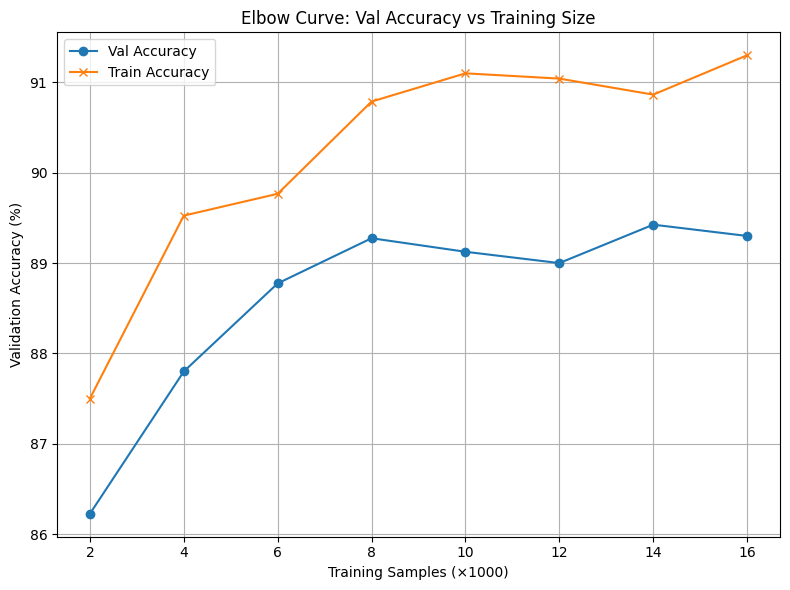

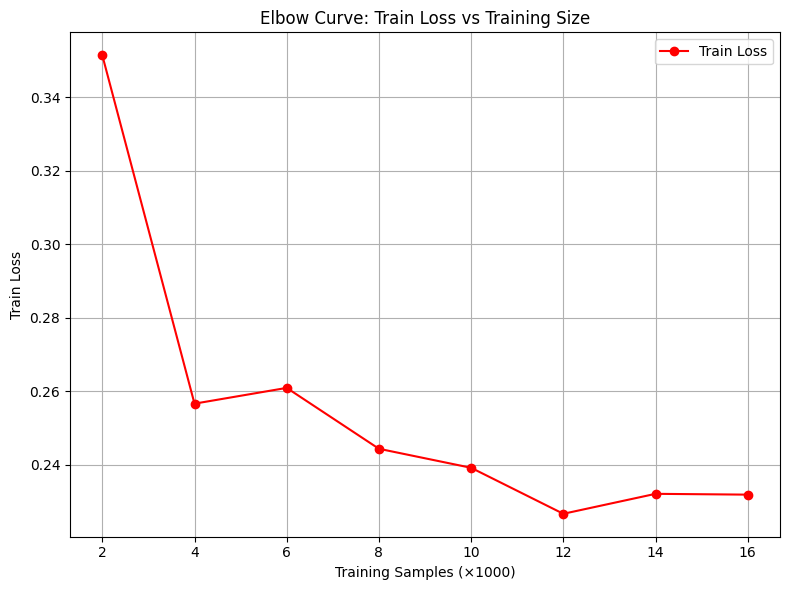

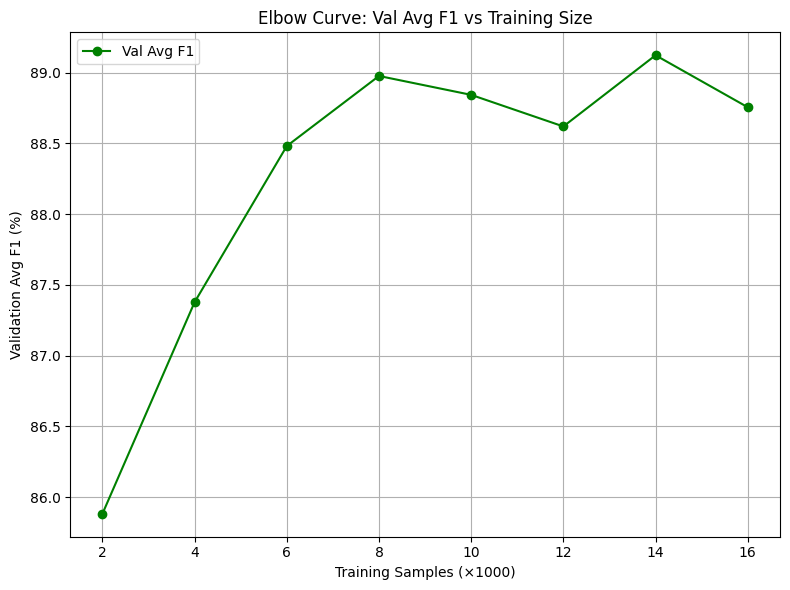

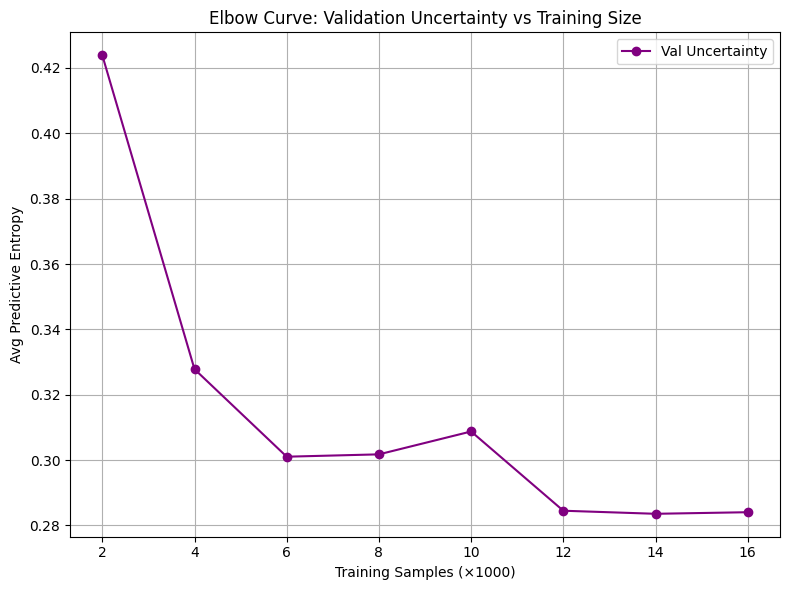

In [41]:
def plot_elbow_curve(elbow_history):
    x_vals = [x // 1000 for x in elbow_history["subset_size"]]

    # Accuracy
    plt.figure(figsize=(8, 6))
    y_vals = [acc * 100 for acc in elbow_history["val_accuracy"]]
    plt.plot(x_vals, y_vals, marker='o', label='Val Accuracy')
    plt.plot(x_vals, [acc * 100 for acc in elbow_history['train_accuracy']], marker='x', label='Train Accuracy')
    plt.xlabel("Training Samples (×1000)")
    plt.ylabel("Validation Accuracy (%)")
    plt.title("Elbow Curve: Val Accuracy vs Training Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Train Loss
    plt.figure(figsize=(8, 6))
    y_vals = elbow_history["train_loss"]  # raw loss
    plt.plot(x_vals, y_vals, marker='o', color='red', label='Train Loss')
    plt.xlabel("Training Samples (×1000)")
    plt.ylabel("Train Loss")
    plt.title("Elbow Curve: Train Loss vs Training Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # F1 Score
    plt.figure(figsize=(8, 6))
    y_vals = [f1 * 100 for f1 in elbow_history["val_avg_f1"]]
    plt.plot(x_vals, y_vals, marker='o', color='green', label='Val Avg F1')
    plt.xlabel("Training Samples (×1000)")
    plt.ylabel("Validation Avg F1 (%)")
    plt.title("Elbow Curve: Val Avg F1 vs Training Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Entropy plot
    plt.figure(figsize=(8, 6))
    y_vals = elbow_history["val_uncertainty"]
    plt.plot(x_vals, y_vals, marker='o', color='purple', label='Val Uncertainty')
    plt.xlabel("Training Samples (×1000)")
    plt.ylabel("Avg Predictive Entropy")
    plt.title("Elbow Curve: Validation Uncert ainty vs Training Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



plot_elbow_curve(elbow_history)

<hr>

## Saving Result to Excel

In [42]:
def save_elbow_results_to_excel(filename, parameters_dict, elbow_history):
    # Convert parameters dict to string
    parameters_str = ", ".join([f"{k} = {v}" for k, v in parameters_dict.items()])

    # Load or create workbook
    if os.path.exists(filename):
        wb = load_workbook(filename)
        ws = wb.active
    else:
        wb = Workbook()
        ws = wb.active

        # Header row with bold font
        headers = ["Experiments", "Parameters", "Results"]
        bold_font = Font(bold=True)
        ws.append(headers)

        for col_num in range(1, len(headers) + 1):
            ws.cell(row=1, column=col_num).font = bold_font

    # For each subset size, append a row
    for i in range(len(elbow_history["subset_size"])):
        subset = elbow_history["subset_size"][i]
        train_acc = elbow_history["train_accuracy"][i] * 100
        train_loss = elbow_history["train_loss"][i]
        val_acc = elbow_history["val_accuracy"][i] * 100
        val_f1 = elbow_history["val_avg_f1"][i]

        experiment_name = f"Labeled Samples: {subset}"
        results_str = (
            f"TrainAcc = {train_acc:.2f}%, "
            f"TrainLoss = {train_loss:.4f}, "
            f"ValAcc = {val_acc:.2f}%, "
            f"Avg F1 = {val_f1:.4f}"
        )

        ws.append([experiment_name, parameters_str, results_str])

    wb.save(filename)
    print(f"Results saved to {filename}")

save_elbow_results_to_excel(
    filename="Results.xlsx",
    parameters_dict=parameters,
    elbow_history=elbow_history
)

Results saved to Results.xlsx


## AL Pipeline Loop

In [ ]:
# num_rounds = 10
# epochs = 50
# query_size = 100 
# sim = 20

# for name, query_func in sampling_strategies.items():
#     print(f"\n======================")
#     print(f" Running strategy: {name.upper()} ")
#     print(f"======================")    

#     labeled_pool = strategy_pools[name]["labeled"]
#     unlabeled_pool = strategy_pools[name]["unlabeled"]
#     print('Length of Labeled Pool:', len(labeled_pool))
#     print('Length of Unlabeled Pool:', len(unlabeled_pool))

#     history = strategy_histories[name]

#     for round_num in range(1, num_rounds + 1):
#         print(f"\n--- Round {round_num} [{name}] ---")

#         # Cold start: Re-initialize model at every round
#         backbone_copy = cnn().to(device)
#         fc_copy = FC(1024).to(device)
#         backbone_copy.load_state_dict(backbone_state)
#         fc_copy.load_state_dict(fc_state)
        
#         # 1. Query k samples
#         queried_indices = query_func(
#             X=X_train,
#             model_backbone=backbone_copy,
#             model_fc=fc_copy,
#             k=query_size,
#             device=device,
#             unlabeled_pool=unlabeled_pool
#         ) if name != "random" else query_func(query_size, unlabeled_pool)
    
#         # 2. Update pools
#         new_indices = set(queried_indices) - labeled_pool  # avoid duplication
#         labeled_pool.update(new_indices)
#         unlabeled_pool.difference_update(new_indices)
#         print('Length of Labeled Pool:', len(labeled_pool))
#         print('Length of Unlabeled Pool:', len(unlabeled_pool))
        
#         # 3. Build train loader
#         train_dataset = SimpleDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
#         train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
#         # 4. Train + Evaluate
#         train(backbone_copy, fc_copy, train_loader, device, epochs=epochs)
#         f1s, acc, avg_f1 = eval_perf(val_dataloader, backbone_copy, fc_copy, device)
        
#         print("Per-class F1 scores:", f1s)
#         print(f"Overall Accuracy: {acc * 100:.2f}%")
#         print(f"Average F1 Score: {avg_f1:.4f}")
    
#         # 5. Update history
#         history["rounds"].append(round_num)
#         history["num_labeled"].append(len(labeled_pool))
#         history["accuracy"].append(acc)
#         history["avg_f1"].append(avg_f1)
#         history["f1s"].append(f1s.tolist())

In [ ]:
# # Accuracy Plot: Train vs Val
# fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

# for i, (name, history) in enumerate(strategy_histories.items()):
#     val_accs = [a * 100 for a in history["val_accuracy"]]
#     train_accs = [acc_list[-1] * 100 for acc_list in history["train_accuracy"]]  # last epoch of each round

#     axs[i].plot(history["num_labeled"], val_accs, marker="o", label="Validation Accuracy", color="blue")
#     axs[i].plot(history["num_labeled"], train_accs, marker="x", linestyle="--", label="Train Accuracy", color="orange")

#     axs[i].set_title(f"{name.capitalize()} Sampling")
#     axs[i].set_xlabel("Labeled Samples")
#     axs[i].set_ylabel("Accuracy (%)")
#     axs[i].legend()
#     axs[i].grid(True)

# plt.tight_layout()
# plt.suptitle("Active Learning Strategy Comparison (Train vs Validation Accuracy)", fontsize=16, y=1.05)
# plt.show()


# # Average F1 Score Plot
# fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
# for i, (name, history) in enumerate(strategy_histories.items()):
#     axs[i].plot(history["num_labeled"], [a * 100 for a in history["val_avg_f1"]], marker="x", color='green')
#     axs[i].set_title(f"{name.capitalize()} Sampling")
#     axs[i].set_xlabel("Labeled Samples")
#     axs[i].set_ylabel("F1 Score (%)")
#     axs[i].grid(True)

# plt.tight_layout()
# plt.suptitle("Active Learning Strategy Comparison (F1 Score)", fontsize=16, y=1.05)
# plt.show()